In [206]:
!python3 -V

Python 3.8.10


In [207]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Table of content
* [1. Reading data](#reading-data)
* [2. Missing values](#missing-values)
* [3. Categorical variables](#cat-variables)
* [4. Continuous variables](#cont-variables)
* [5. Eda - different comparisons](#eda-comparisons)
    * [5.1 Check number of missing values per hospital](#eda-comparison-51)
    * [5.2 Check missing values per features per hospitals](#eda-comparison-52)
    * [5.3 Check percentage of missing values per features per hospitals](#eda-comparison-53)
* [6. Eda - Classification](#classification)
    * [6.1 Imputing NaN values with a constant](#classification-61)
        * [6.1.1 Xgb prediction, Imputing NaN values with a constant](#classification-611)
    * [6.2 Imputing NaN values with random samples from columns](#classification-62)
* [7. Imputation functions](#imputationfunctions)
    * [7.1 Imputation functions - population sampling](#imputationfunctions-71)
    * [7.2  Imputation functions  - population average](#imputationfunctions-72)
* [8. Line by line imputation functions](#llimputationfunctions)
    * [8.1 Line by line imputation functions - population average](#llimputationfunctions-81)
    * [8.2 Line by line imputation functions - population sampling](#llimputationfunctions-82)
    * [8.3 Line by line imputation functions - age average](#llimputationfunctions-83)
    * [8.4 Line by line imputation functions - hospital average](#llimputationfunctions-84)
    * [8.5 Line by line imputation functions - hospital sampling](#llimputationfunctions-85)
* [9. Test data - EDA](#testdataeda)

## 1. Reading data <a class="anchor" id="reading-data"></a>

In [208]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import plotly.express as px
import math

from sklearn import metrics, model_selection
from sklearn.preprocessing import scale, normalize
from sklearn import datasets, cluster
from sklearn import neighbors, ensemble, tree, linear_model
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [209]:
data_raw = pd.read_excel('../data/raw_data/trainClinData.xls')

In [9]:
data_raw.head()

Row_number  ImageFile Hospital        Age  Sex  PositivityAtAdmission  \
0          82  P_102.png        A  72.000000    1                    1.0   
1         228  P_131.png        D  35.913889    0                    1.0   
2         229  P_132.png        D  57.266667    0                    1.0   
3          96  P_117.png        A  39.000000    1                    1.0   
4         112   P_16.png        A  44.000000    0                    1.0   

   Temp_C  DaysFever  Cough  DifficultyInBreathing  ...  Diabetes  Dementia  \
0    37.3        3.0    1.0                    0.0  ...       0.0       0.0   
1    39.3        3.0    1.0                    0.0  ...       0.0       0.0   
2    37.0        3.0    0.0                    0.0  ...       0.0       0.0   
3    37.2        2.0    1.0                    0.0  ...       0.0       0.0   
4    38.0        3.0    1.0                    0.0  ...       0.0       0.0   

   BPCO  Cancer  ChronicKidneyDisease  RespiratoryFailure  Obesity  Position  \
0   0.0     1.0                   0.0                 0.0      0.0       0.0   
1   0.0     0.0                   0.0                 NaN      1.0       0.0   
2   0.0     0.0                   0.0                 NaN      NaN       0.0   
3   0.0     0.0                   0.0                 0.0      0.0       1.0   
4   0.0     0.0                   0.0                 0.0      0.0       0.0   

   Prognosis  Death  
0     SEVERE      0  
1       MILD      0  
2       MILD      0  
3       MILD      0  
4     SEVERE      0  

[5 rows x 40 columns]

In [10]:
data_raw.columns

Index(['Row_number', 'ImageFile', 'Hospital', 'Age', 'Sex',
       'PositivityAtAdmission', 'Temp_C', 'DaysFever', 'Cough',
       'DifficultyInBreathing', 'WBC', 'RBC', 'CRP', 'Fibrinogen', 'Glucose',
       'PCT', 'LDH', 'INR', 'D_dimer', 'Ox_percentage', 'PaO2', 'SaO2',
       'PaCO2', 'pH', 'CardiovascularDisease', 'IschemicHeartDisease',
       'AtrialFibrillation', 'HeartFailure', 'Ictus', 'HighBloodPressure',
       'Diabetes', 'Dementia', 'BPCO', 'Cancer', 'ChronicKidneyDisease',
       'RespiratoryFailure', 'Obesity', 'Position', 'Prognosis', 'Death'],
      dtype='object')

In [11]:
data_raw.shape

(1103, 40)

In [12]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1103 entries, 0 to 1102
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Row_number             1103 non-null   int64  
 1   ImageFile              1103 non-null   object 
 2   Hospital               1103 non-null   object 
 3   Age                    1102 non-null   float64
 4   Sex                    1103 non-null   int64  
 5   PositivityAtAdmission  1064 non-null   float64
 6   Temp_C                 943 non-null    float64
 7   DaysFever              859 non-null    float64
 8   Cough                  1098 non-null   float64
 9   DifficultyInBreathing  1099 non-null   float64
 10  WBC                    1083 non-null   float64
 11  RBC                    1057 non-null   float64
 12  CRP                    1059 non-null   float64
 13  Fibrinogen             272 non-null    float64
 14  Glucose                903 non-null    float64
 15  PCT 

In [13]:
data_raw.describe()

Row_number          Age          Sex  PositivityAtAdmission  \
count  1103.000000  1102.000000  1103.000000            1064.000000   
mean    568.906618    64.601433     0.346328               0.957707   
std     334.640378    15.094092     0.476015               0.201352   
min       1.000000    18.000000     0.000000               0.000000   
25%     279.500000    54.000000     0.000000               1.000000   
50%     562.000000    65.000000     0.000000               1.000000   
75%     906.500000    77.000000     1.000000               1.000000   
max    1116.000000    99.718001     1.000000               1.000000   

           Temp_C   DaysFever        Cough  DifficultyInBreathing  \
count  943.000000  859.000000  1098.000000            1099.000000   
mean    37.551856    2.722934     0.522769               0.505005   
std      0.982271    1.020797     0.499709               0.500203   
min     35.400000    0.000000     0.000000               0.000000   
25%     36.800000    2.000000     0.000000               0.000000   
50%     37.600000    3.000000     1.000000               1.000000   
75%     38.200000    4.000000     1.000000               1.000000   
max     41.500000    4.000000     1.000000               1.000000   

               WBC          RBC  ...  HighBloodPressure    Diabetes  \
count  1083.000000  1057.000000  ...         966.000000  966.000000   
mean      7.100424     4.572201  ...           0.458592    0.155280   
std       3.835440     0.708783  ...           0.498541    0.362359   
min       0.200000     0.256250  ...           0.000000    0.000000   
25%       4.660000     4.200000  ...           0.000000    0.000000   
50%       6.260000     4.610000  ...           0.000000    0.000000   
75%       8.430000     5.040000  ...           1.000000    0.000000   
max      52.310000     7.900000  ...           1.000000    1.000000   

         Dementia        BPCO      Cancer  ChronicKidneyDisease  \
count  963.000000  966.000000  966.000000            966.000000   
mean     0.045691    0.069358    0.073499              0.066253   
std      0.208922    0.254194    0.261089              0.248852   
min      0.000000    0.000000    0.000000              0.000000   
25%      0.000000    0.000000    0.000000              0.000000   
50%      0.000000    0.000000    0.000000              0.000000   
75%      0.000000    0.000000    0.000000              0.000000   
max      1.000000    1.000000    1.000000              1.000000   

       RespiratoryFailure     Obesity    Position        Death  
count          824.000000  544.000000  983.000000  1103.000000  
mean             0.016990    0.110294    0.804680     0.174977  
std              0.129313    0.313544    0.396649     0.380120  
min              0.000000    0.000000    0.000000     0.000000  
25%              0.000000    0.000000    1.000000     0.000000  
50%              0.000000    0.000000    1.000000     0.000000  
75%              0.000000    0.000000    1.000000     0.000000  
max              1.000000    1.000000    1.000000     1.000000  

[8 rows x 37 columns]

## 2. Missing values <a class="anchor" id="missing-values"></a>

In [14]:
data_raw.isna().sum()

Row_number                 0
ImageFile                  0
Hospital                   0
Age                        1
Sex                        0
PositivityAtAdmission     39
Temp_C                   160
DaysFever                244
Cough                      5
DifficultyInBreathing      4
WBC                       20
RBC                       46
CRP                       44
Fibrinogen               831
Glucose                  200
PCT                      655
LDH                      258
INR                      286
D_dimer                  787
Ox_percentage            364
PaO2                     270
SaO2                     673
PaCO2                    291
pH                       327
CardiovascularDisease    139
IschemicHeartDisease     274
AtrialFibrillation       142
HeartFailure             143
Ictus                    143
HighBloodPressure        137
Diabetes                 137
Dementia                 140
BPCO                     137
Cancer                   137
ChronicKidneyD

In [15]:
data_raw.isna().sum().sum()

8129

<AxesSubplot:>

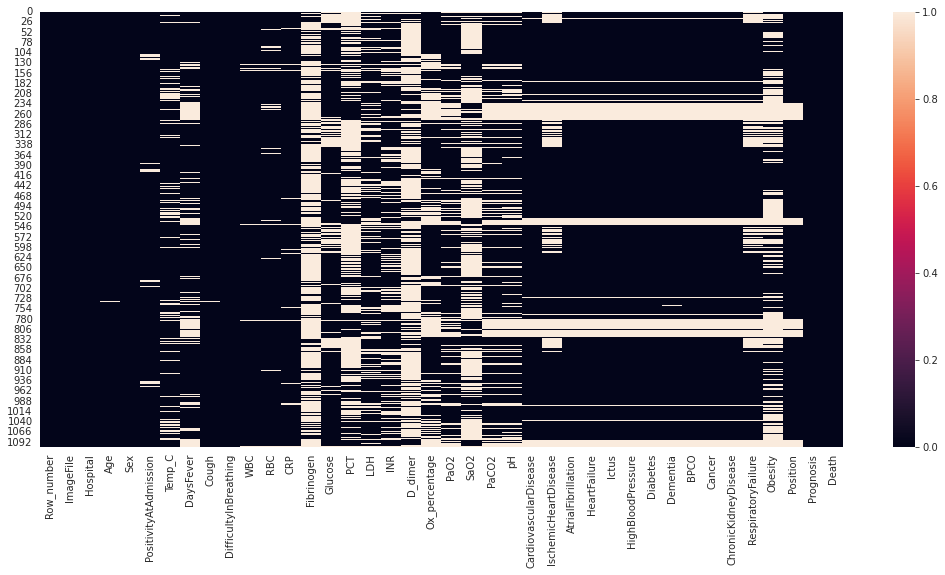

In [16]:
plt.figure(figsize=(18,8))
sns.set_style(style='white')
sns.heatmap(data_raw.isna())

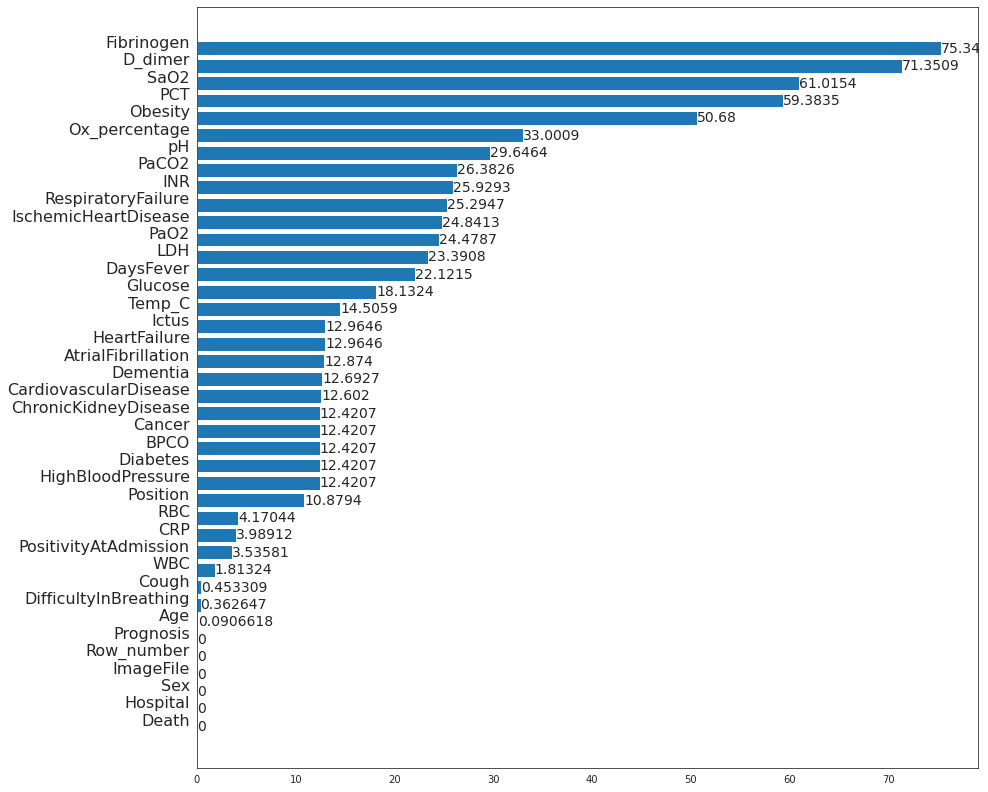

In [17]:
percent_missing = data_raw.isnull().sum() * 100 / len(data_raw)
missing_value_df = pd.DataFrame({'column_name': data_raw.columns, 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True, ascending=False)



fig, ax = plt.subplots(figsize=(14,14))
hbars = ax.barh(missing_value_df['column_name'], missing_value_df['percent_missing'], align='edge')
ax.invert_yaxis()
ax.bar_label(hbars, size=14)
ax.yaxis.set_tick_params(labelsize=16)

In [18]:
data_raw.corr().style.background_gradient(cmap="Blues")

## 3. Categorical variables <a class="anchor" id="cat-variables"></a>

In [19]:
def plot_categorical(column_name):
    g = sns.catplot(x=column_name, data=data_raw, kind='count')
    sns.set(font_scale=1.1)
    ax = g.facet_axis(0,0)
    for p in ax.patches:
        ax.text(p.get_x(), 
                p.get_height() * 1.04, 
                p.get_height(), 
                color='black', rotation='horizontal', size='large')

In [20]:
def subplot_categorical(ind_axes, column_name):
    g = sns.countplot(ax=ind_axes, data=data_raw, x=column_name)
    g.axes.set_title(column_name, fontsize=18)
    g.axes.set_xlabel("")
    g.set_ylabel("count",fontsize=18)
    g.tick_params(labelsize=16)
    ax = g.axes
    for p in ax.patches:
        ax.text(p.get_x(), 
                p.get_height()/2, 
                p.get_height(), 
                color='black', rotation='horizontal', size='x-large')

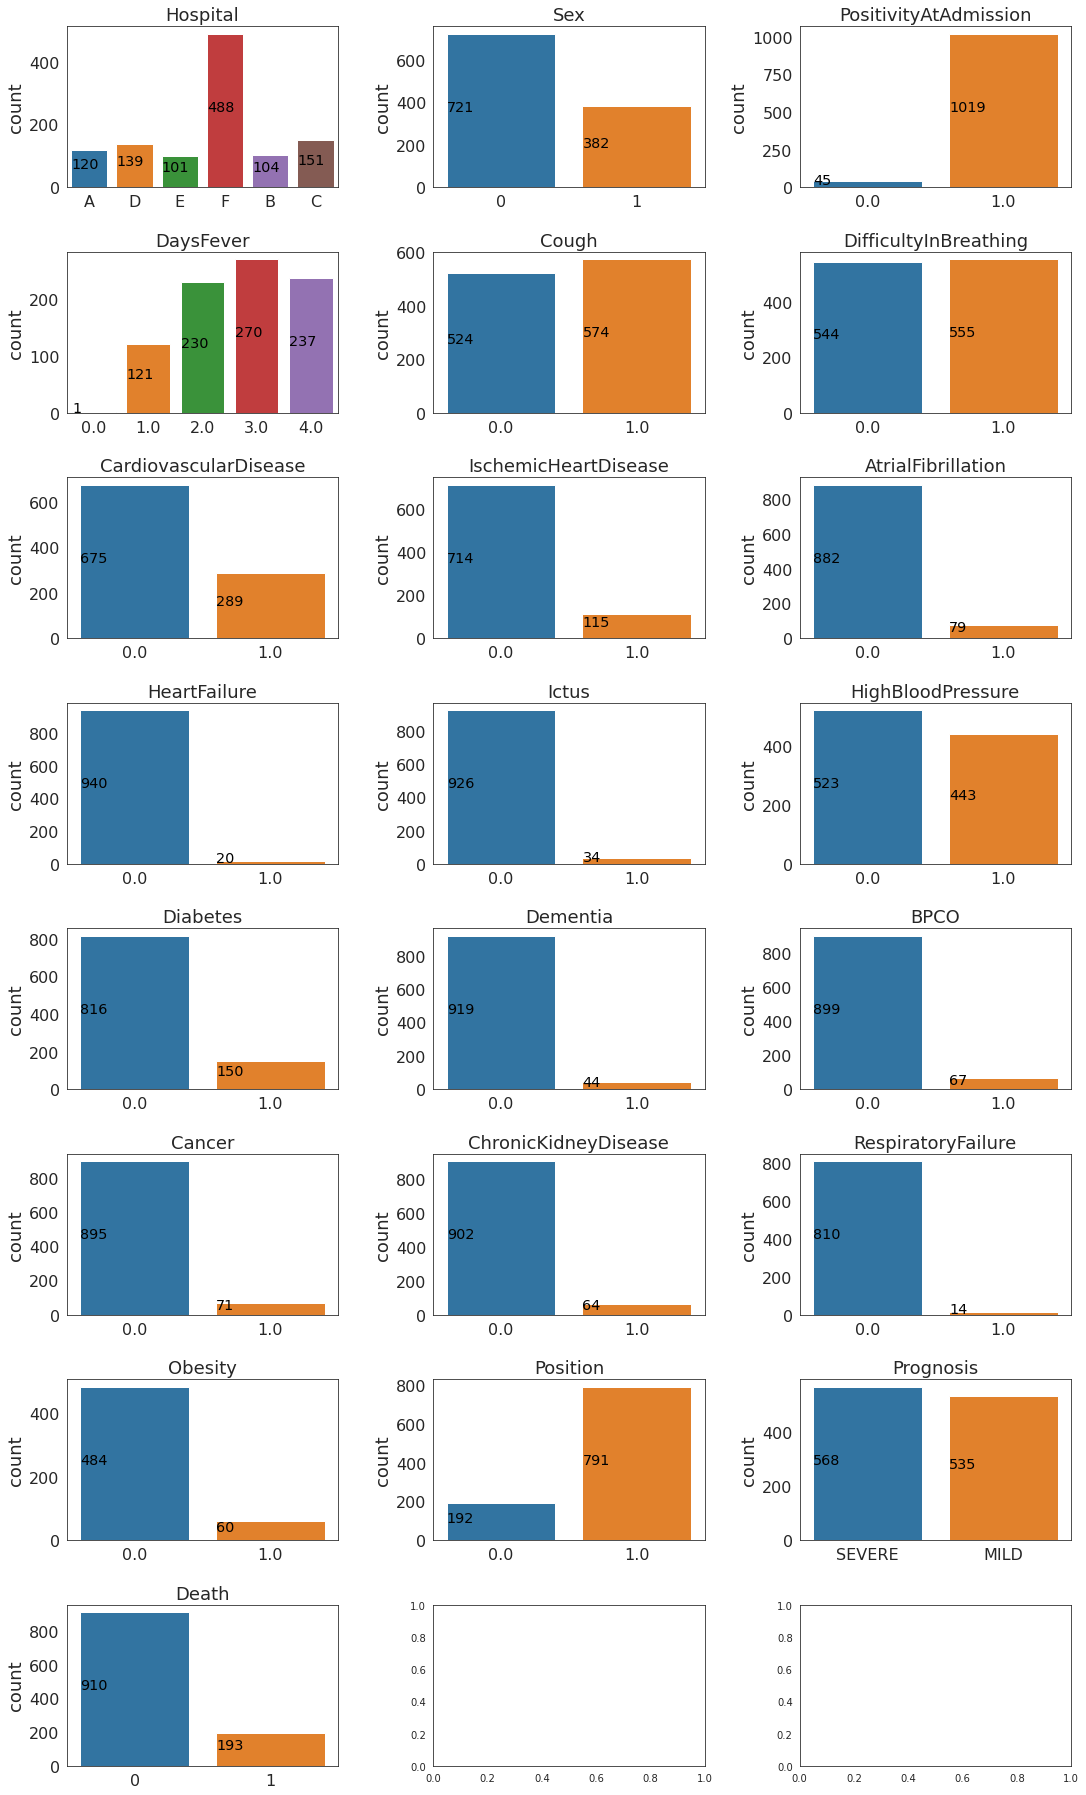

In [21]:
fig, axes = plt.subplots(8, 3,figsize=(18, 32))
plt.subplots_adjust(hspace = 0.4)
plt.subplots_adjust(wspace = 0.35)
subplot_categorical(axes[0, 0], 'Hospital')
subplot_categorical(axes[0, 1], 'Sex')
subplot_categorical(axes[0, 2], 'PositivityAtAdmission')
subplot_categorical(axes[1, 0], 'DaysFever')
subplot_categorical(axes[1, 1], 'Cough')
subplot_categorical(axes[1, 2], 'DifficultyInBreathing')
subplot_categorical(axes[2, 0], 'CardiovascularDisease')
subplot_categorical(axes[2, 1], 'IschemicHeartDisease')
subplot_categorical(axes[2, 2], 'AtrialFibrillation')
subplot_categorical(axes[3, 0], 'HeartFailure')
subplot_categorical(axes[3, 1], 'Ictus')
subplot_categorical(axes[3, 2], 'HighBloodPressure')
subplot_categorical(axes[4, 0], 'Diabetes')
subplot_categorical(axes[4, 1], 'Dementia')
subplot_categorical(axes[4, 2], 'BPCO')
subplot_categorical(axes[5, 0], 'Cancer')
subplot_categorical(axes[5, 1], 'ChronicKidneyDisease')
subplot_categorical(axes[5, 2], 'RespiratoryFailure')
subplot_categorical(axes[6, 0], 'Obesity')
subplot_categorical(axes[6, 1], 'Position')
subplot_categorical(axes[6, 2], 'Prognosis')
subplot_categorical(axes[7, 0], 'Death')

## 4. Continuous variables <a class="anchor" id="cont-variables"></a>

In [22]:
def subplot_numerical(ind_axes, column_name):
    b = sns.histplot(ax=ind_axes, data=data_raw, x=column_name).axes.set_title(column_name, fontsize=16)
    b.axes.set_xlabel("")

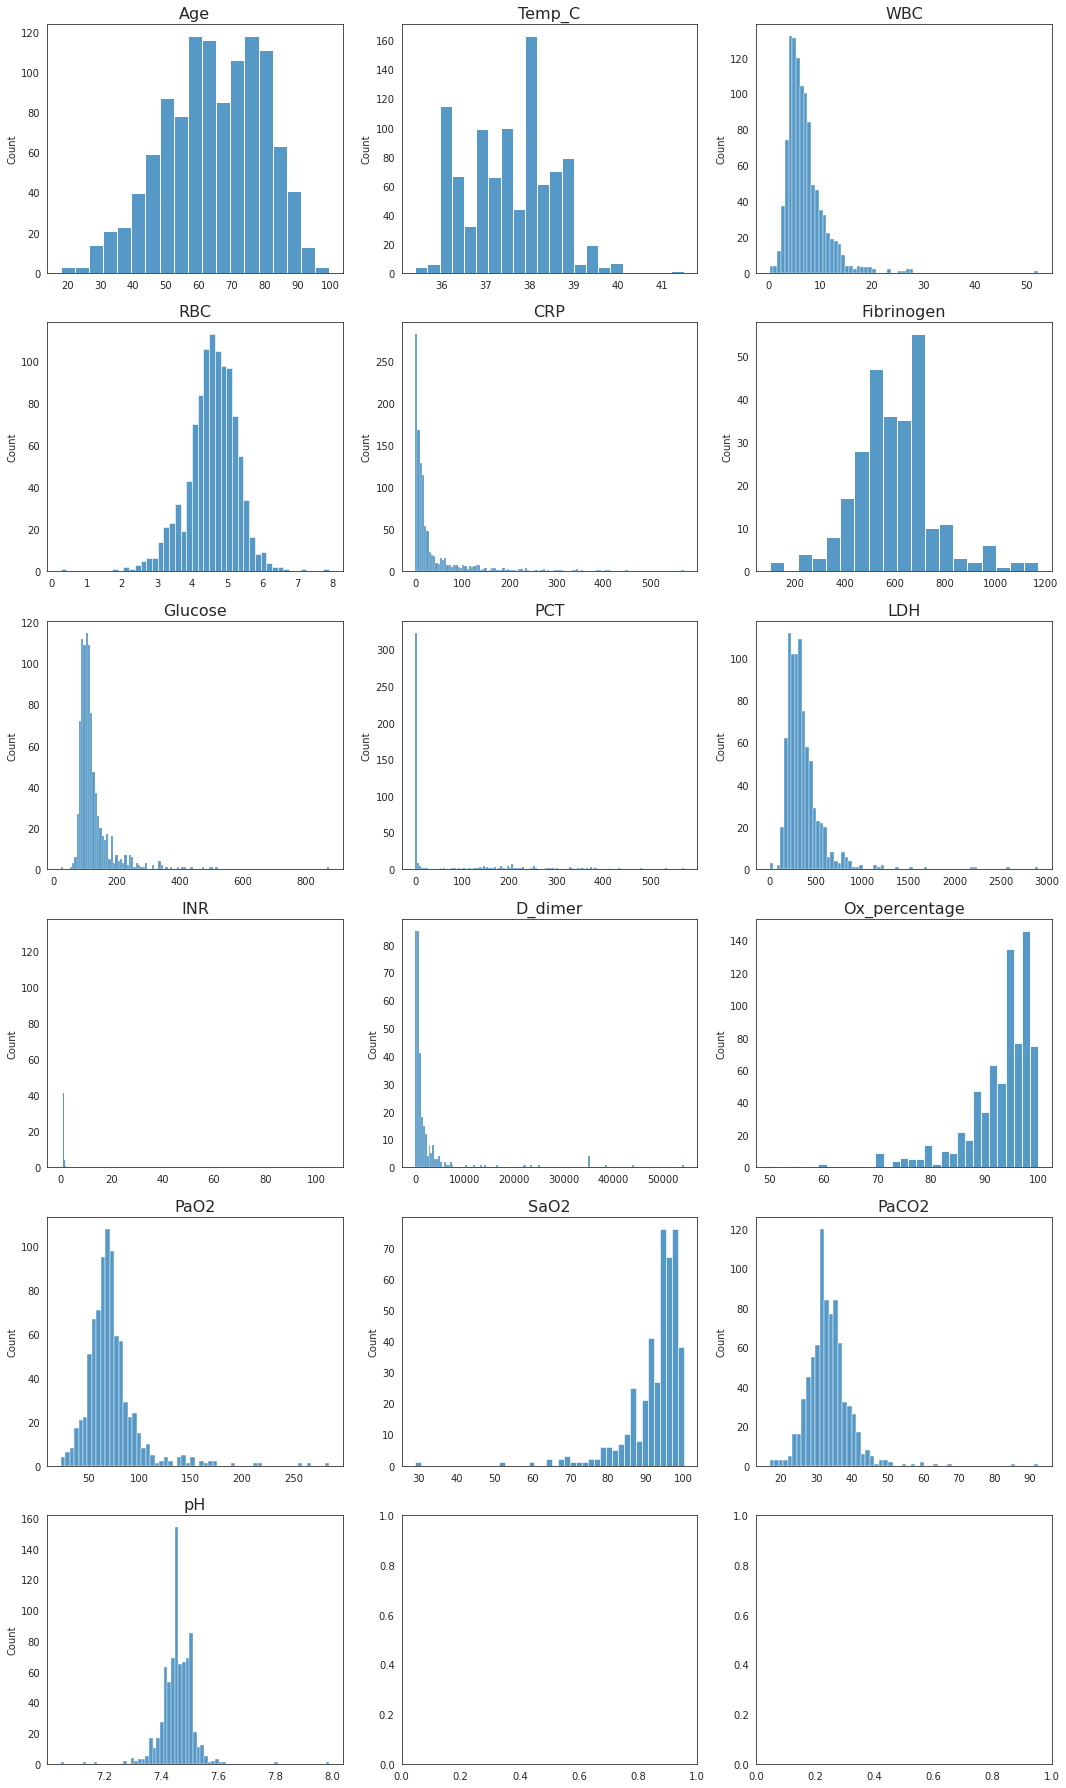

In [23]:
fig, axes = plt.subplots(6, 3,figsize=(18, 32))
subplot_numerical(axes[0, 0], 'Age')
subplot_numerical(axes[0, 1], 'Temp_C')
subplot_numerical(axes[0, 2], 'WBC')
subplot_numerical(axes[1, 0], 'RBC')
subplot_numerical(axes[1, 1], 'CRP')
subplot_numerical(axes[1, 2], 'Fibrinogen')
subplot_numerical(axes[2, 0], 'Glucose')
subplot_numerical(axes[2, 1], 'PCT')
subplot_numerical(axes[2, 2], 'LDH')
subplot_numerical(axes[3, 0], 'INR')
subplot_numerical(axes[3, 1], 'D_dimer')
subplot_numerical(axes[3, 2], 'Ox_percentage')
subplot_numerical(axes[4, 0], 'PaO2')
subplot_numerical(axes[4, 1], 'SaO2')
subplot_numerical(axes[4, 2], 'PaCO2')
subplot_numerical(axes[5, 0], 'pH')

## 5. EDA different comparisons <a class="anchor" id="eda-comparisons"></a>

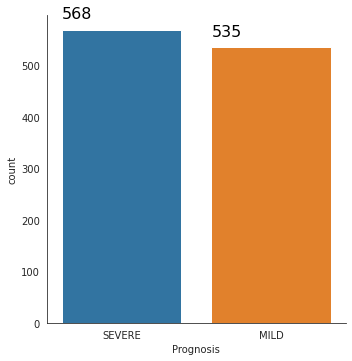

In [24]:
plot_categorical("Prognosis")
sns.set(font_scale=1.4)
sns.set_style(style='white')

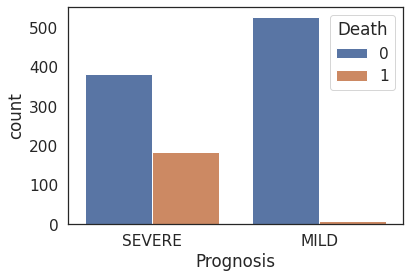

In [25]:
sns.set_style(style='white')
sns.countplot(data=data_raw, x="Prognosis", hue="Death")
sns.set(font_scale=1.4)
sns.set_style(style='white')

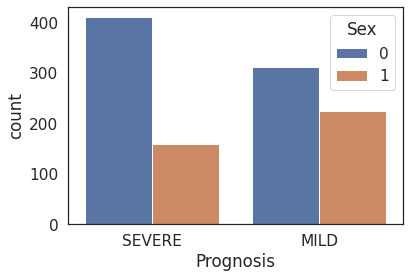

In [26]:
sns.set_style(style='white')
sns.countplot(data=data_raw, x="Prognosis", hue="Sex")
sns.set(font_scale=1.4)
sns.set_style(style='white')

<AxesSubplot:xlabel='Prognosis', ylabel='count'>

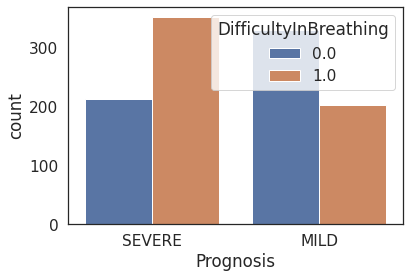

In [27]:
sns.countplot(data=data_raw, x="Prognosis", hue="DifficultyInBreathing")

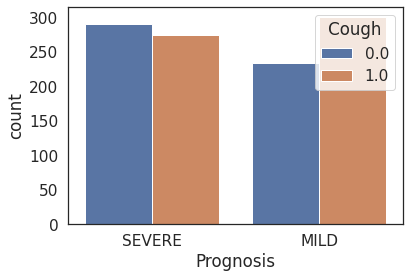

In [28]:
sns.countplot(data=data_raw, x="Prognosis", hue="Cough")
sns.set(font_scale=1.4)
sns.set_style(style='white')

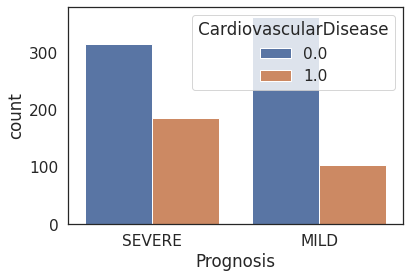

In [29]:
sns.countplot(data=data_raw, x="Prognosis", hue="CardiovascularDisease")
sns.set(font_scale=1.4)
sns.set_style(style='white')

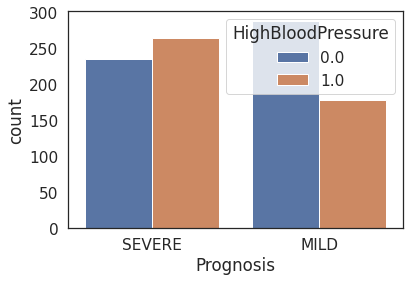

In [30]:
sns.countplot(data=data_raw, x="Prognosis", hue="HighBloodPressure")
sns.set(font_scale=1.4)
sns.set_style(style='white')

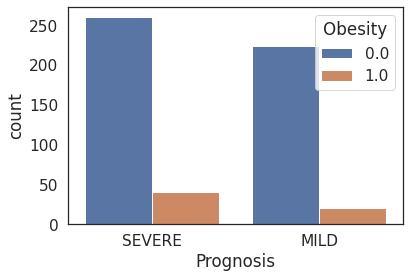

In [31]:
sns.countplot(data=data_raw, x="Prognosis", hue="Obesity")
sns.set(font_scale=1.4)
sns.set_style(style='white')

<Figure size 1008x1008 with 0 Axes>

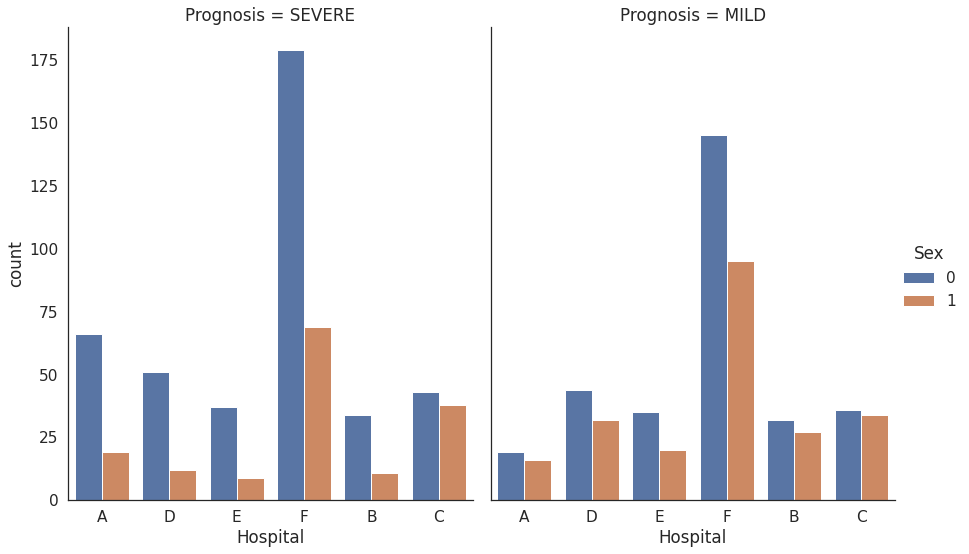

In [32]:
plt.figure(figsize=(14,14))
sns.catplot(x="Hospital", hue="Sex", col="Prognosis",
                data=data_raw, kind="count",
                height=8, aspect=.8);
sns.set(font_scale=1.4)
sns.set_style(style='white')

<Figure size 1008x1008 with 0 Axes>

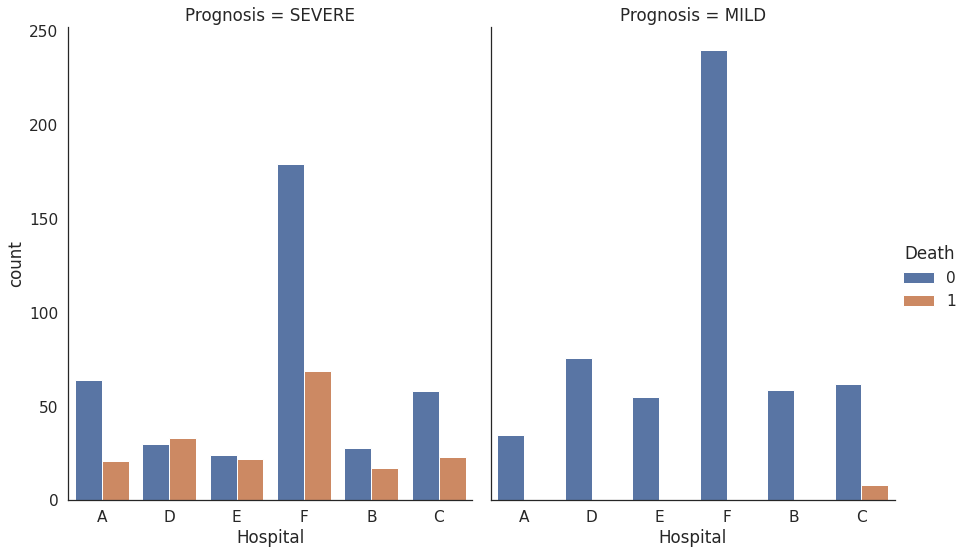

In [33]:
plt.figure(figsize=(14,14))
sns.catplot(x="Hospital", hue="Death", col="Prognosis",
                data=data_raw, kind="count",
                height=8, aspect=.8);
sns.set(font_scale=1.4)
sns.set_style(style='white')

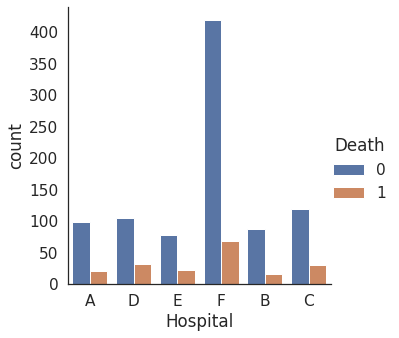

In [34]:
sns.catplot(x="Hospital", hue="Death", kind="count", data=data_raw)
sns.set(font_scale=1.4)
sns.set_style(style='white')

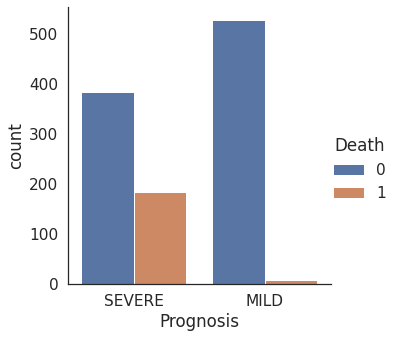

In [35]:
sns.catplot(x="Prognosis", hue="Death", kind="count", data=data_raw)

<Figure size 1008x1008 with 0 Axes>

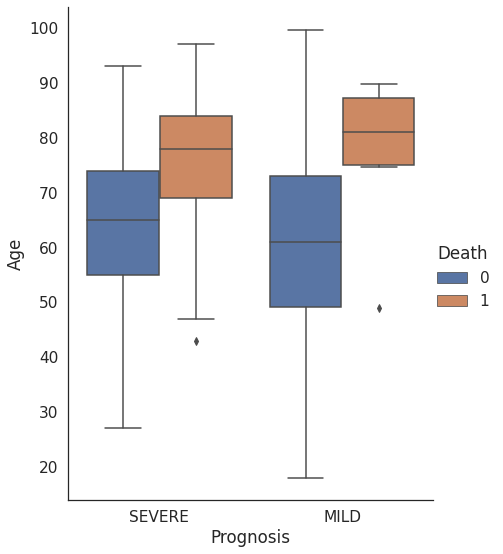

In [36]:
plt.figure(figsize=(14,14))
sns.catplot(x="Prognosis", hue="Death", y="Age",
                data=data_raw, kind="box",
                height=8, aspect=.8);
sns.set(font_scale=1.3)
sns.set_style(style='white')

<Figure size 1008x1008 with 0 Axes>

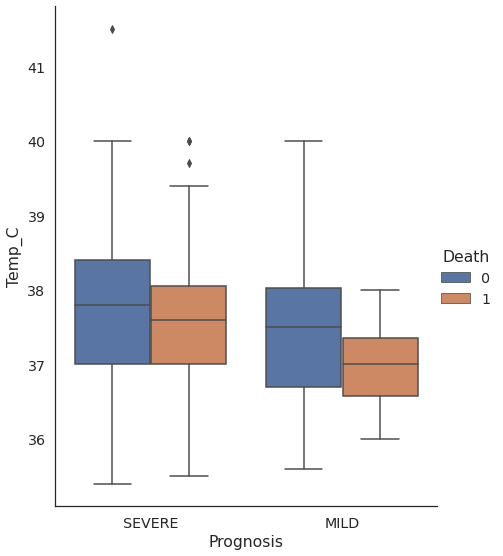

In [37]:
plt.figure(figsize=(14,14))
sns.catplot(x="Prognosis", hue="Death", y="Temp_C",
                data=data_raw, kind="box",
                height=8, aspect=.8);
sns.set(font_scale=1.4)
sns.set_style(style='white')

<Figure size 1008x1008 with 0 Axes>

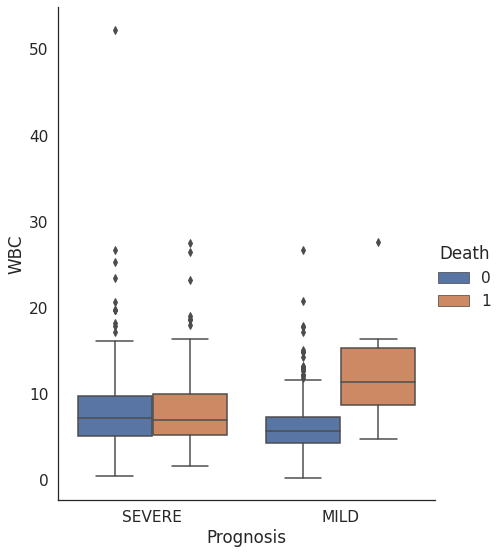

In [38]:
plt.figure(figsize=(14,14))
sns.catplot(x="Prognosis", hue="Death", y="WBC",
                data=data_raw, kind="box",
                height=8, aspect=.8);
sns.set(font_scale=1.4)
sns.set_style(style='white')

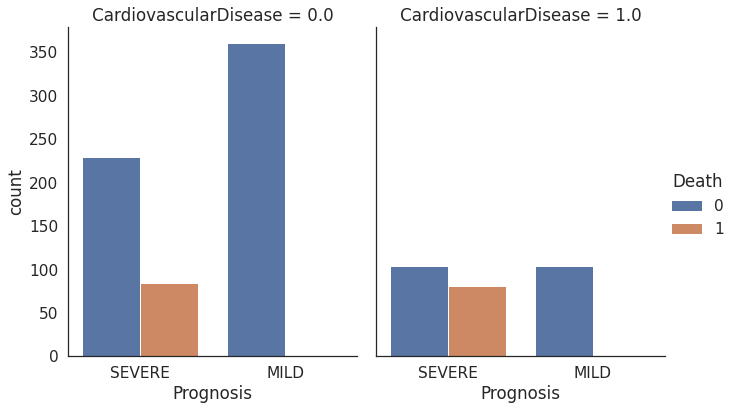

In [39]:
sns.catplot(x="Prognosis", hue="Death", col="CardiovascularDisease",
                data=data_raw, kind="count",
                height=6, aspect=.8);
sns.set(font_scale=1.4)
sns.set_style(style='white')

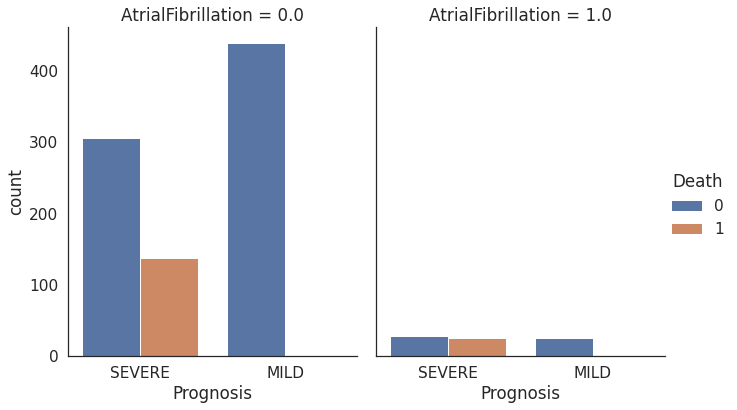

In [40]:
sns.catplot(x="Prognosis", hue="Death", col="AtrialFibrillation",
                data=data_raw, kind="count",
                height=6, aspect=.8);
sns.set(font_scale=1.4)
sns.set_style(style='white')

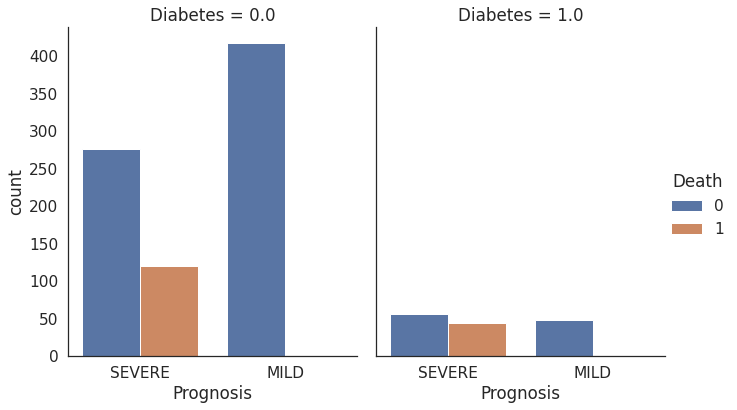

In [41]:
sns.catplot(x="Prognosis", hue="Death", col="Diabetes",
                data=data_raw, kind="count",
                height=6, aspect=.8);
sns.set(font_scale=1.4)
sns.set_style(style='white')

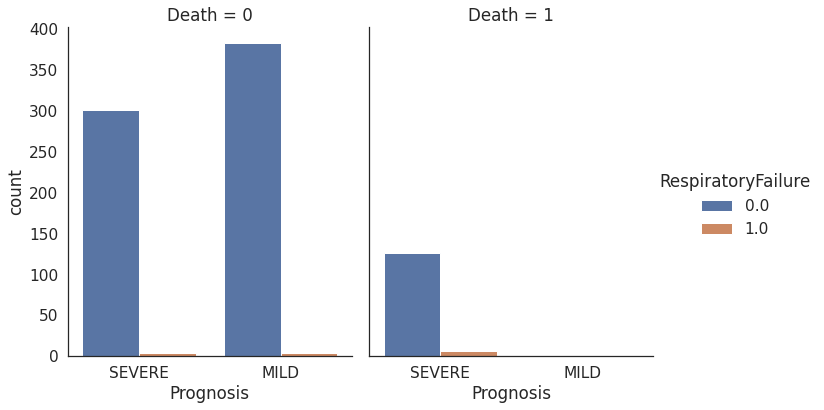

In [42]:
sns.catplot(x="Prognosis", hue="RespiratoryFailure", col="Death",
                data=data_raw, kind="count",
                height=6, aspect=.8);
sns.set(font_scale=1.4)
sns.set_style(style='white')

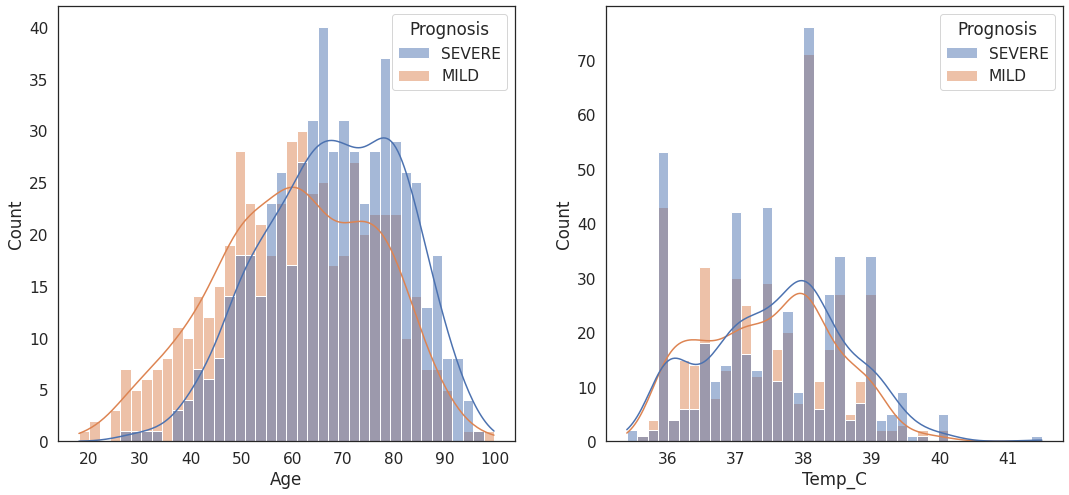

In [43]:
fig, axes = plt.subplots(1, 2,figsize=(18, 8))
sns.histplot(ax=axes[0], data=data_raw, x="Age", hue="Prognosis", bins=40, kde="True")
sns.histplot(ax=axes[1], data=data_raw, x="Temp_C", hue="Prognosis", bins=40, kde="True")
sns.set(font_scale=1.4)
sns.set_style(style='white')

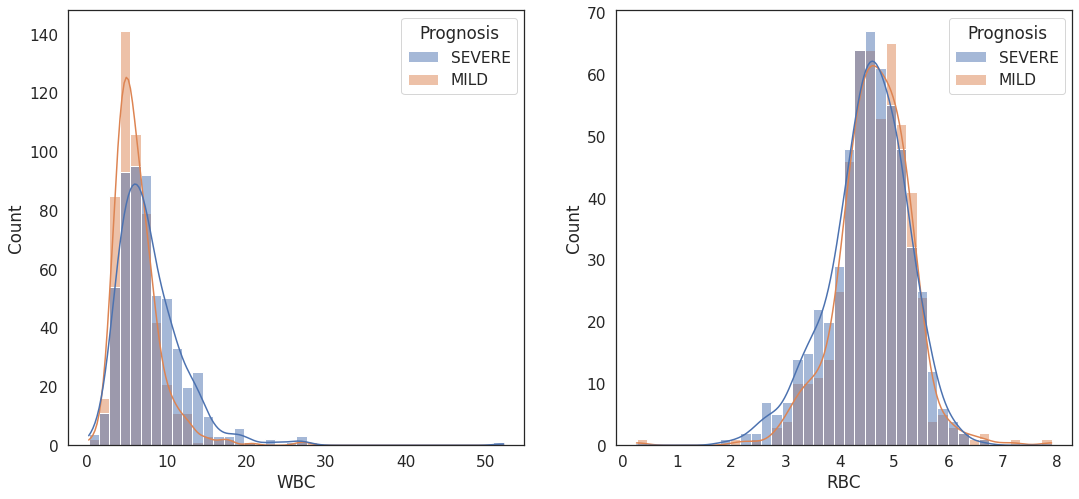

In [44]:
fig, axes = plt.subplots(1, 2,figsize=(18, 8))
sns.histplot(ax=axes[0], data=data_raw, x="WBC", hue="Prognosis", bins=40, kde="True")
sns.histplot(ax=axes[1], data=data_raw, x="RBC", hue="Prognosis", bins=40, kde="True")
sns.set(font_scale=1.4)
sns.set_style(style='white')

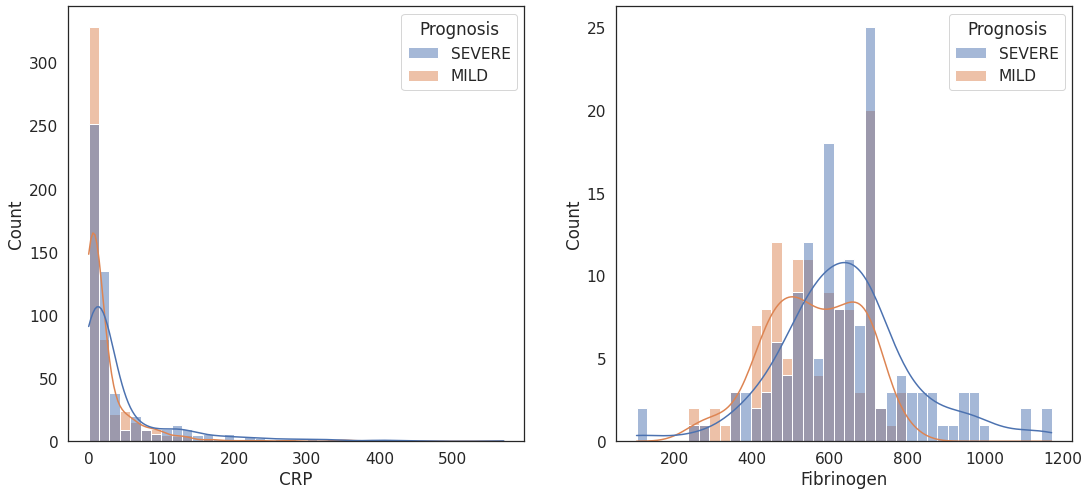

In [45]:
fig, axes = plt.subplots(1, 2,figsize=(18, 8))
sns.histplot(ax=axes[0], data=data_raw, x="CRP", hue="Prognosis", bins=40, kde="True")
sns.histplot(ax=axes[1], data=data_raw, x="Fibrinogen", hue="Prognosis", bins=40, kde="True")
sns.set(font_scale=1.4)
sns.set_style(style='white')

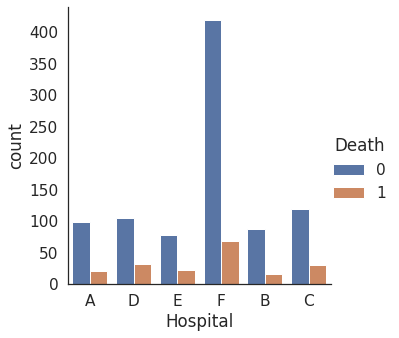

In [46]:
sns.catplot(x="Hospital", hue="Death", kind="count", data=data_raw)
sns.set(font_scale=1.4)
sns.set_style(style='white')

### 5.1 Check number of missing values per hospital <a class="anchor" id="eda-comparison-51"></a>

In [47]:
data_raw.head()

Row_number  ImageFile Hospital        Age  Sex  PositivityAtAdmission  \
0          82  P_102.png        A  72.000000    1                    1.0   
1         228  P_131.png        D  35.913889    0                    1.0   
2         229  P_132.png        D  57.266667    0                    1.0   
3          96  P_117.png        A  39.000000    1                    1.0   
4         112   P_16.png        A  44.000000    0                    1.0   

   Temp_C  DaysFever  Cough  DifficultyInBreathing  ...  Diabetes  Dementia  \
0    37.3        3.0    1.0                    0.0  ...       0.0       0.0   
1    39.3        3.0    1.0                    0.0  ...       0.0       0.0   
2    37.0        3.0    0.0                    0.0  ...       0.0       0.0   
3    37.2        2.0    1.0                    0.0  ...       0.0       0.0   
4    38.0        3.0    1.0                    0.0  ...       0.0       0.0   

   BPCO  Cancer  ChronicKidneyDisease  RespiratoryFailure  Obesity  Position  \
0   0.0     1.0                   0.0                 0.0      0.0       0.0   
1   0.0     0.0                   0.0                 NaN      1.0       0.0   
2   0.0     0.0                   0.0                 NaN      NaN       0.0   
3   0.0     0.0                   0.0                 0.0      0.0       1.0   
4   0.0     0.0                   0.0                 0.0      0.0       0.0   

   Prognosis  Death  
0     SEVERE      0  
1       MILD      0  
2       MILD      0  
3       MILD      0  
4     SEVERE      0  

[5 rows x 40 columns]

In [48]:
#data_raw.drop(['ImageFile', 'Prognosis'], axis=1, inplace=True)
data_raw_grouped = data_raw.groupby("Hospital")
#data_raw_grouped.first()
#data_raw_grouped.get_group("A").isna().sum().sum()

In [49]:
total = 0
miss_vals = []
#print("Missing values in hospitals:")
for H in list(data_raw_grouped.groups.keys()):
    #print(f"{H}: {data_raw_grouped.get_group(H).isna().sum().sum()}")
    miss_vals.append(data_raw_grouped.get_group(H).isna().sum().sum())
    total += data_raw_grouped.get_group(H).isna().sum().sum()
#print("Total missing values: ", total)

In [50]:
df_miss_vals = pd.DataFrame({'Hospital': list(data_raw_grouped.groups.keys()), 'Missing values': miss_vals})
df_miss_vals

Hospital  Missing values
0        A             600
1        B             297
2        C            2818
3        D            1069
4        E             533
5        F            2812

Text(0.5, 1.0, 'Missing values in hospitals')

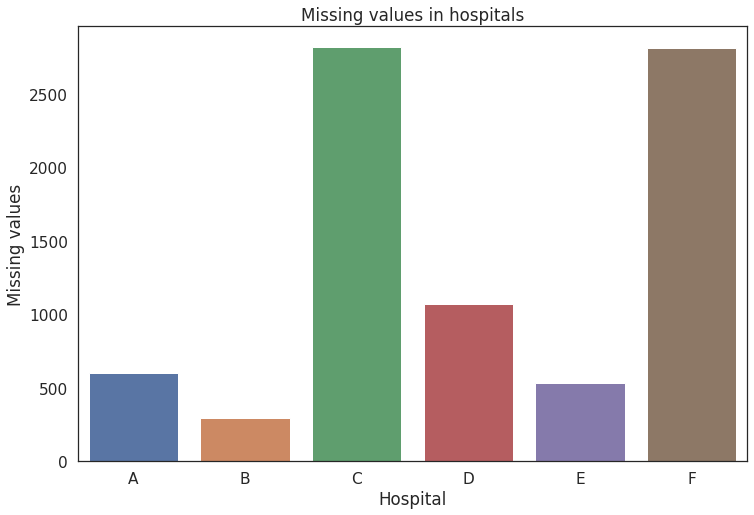

In [51]:
plt.figure(figsize=(12,8))
sns.barplot(data=df_miss_vals, x="Hospital", y="Missing values").set_title("Missing values in hospitals")

### 5.2 Check missing values per features per hospitals <a class="anchor" id="eda-comparison-52"></a>

In [52]:
df_miss_vals_per_hospital = pd.DataFrame()
for hospital in list(data_raw_grouped.groups.keys()):
    df_miss_vals_per_hospital[hospital] = data_raw_grouped.get_group(hospital).isna().sum()

In [53]:
df_miss_vals_per_hospital

A   B    C    D    E    F
Row_number               0   0    0    0    0    0
ImageFile                0   0    0    0    0    0
Hospital                 0   0    0    0    0    0
Age                      0   0    0    0    0    1
Sex                      0   0    0    0    0    0
PositivityAtAdmission    0  39    0    0    0    0
Temp_C                   0   0    6   32    5  117
DaysFever                0   2  151   18    6   67
Cough                    0   0    0    1    0    4
DifficultyInBreathing    0   0    0    1    0    3
WBC                      0   1   14    1    0    4
RBC                      0   1   22    2    1   20
CRP                      0   5   21    1    2   15
Fibrinogen             120  45  151   53   95  367
Glucose                  0   7   21  139    6   27
PCT                    120  30   28  139   99  239
LDH                     80   5   57   37   28   51
INR                     65   3   26    7   20  165
D_dimer                118  48   68   45  101  407
Ox_percentage            1  68  151    9    1  134
PaO2                    12   7  114   35   23   79
SaO2                    62  16   38   50  101  406
PaCO2                   11  10  135   35   22   78
pH                      11  10  135   40   23  108
CardiovascularDisease    0   0  120    2    0   17
IschemicHeartDisease     0   0  120  139    0   15
AtrialFibrillation       0   0  120    2    0   20
HeartFailure             0   0  120    2    0   21
Ictus                    0   0  120    2    0   21
HighBloodPressure        0   0  120    2    0   15
Diabetes                 0   0  120    2    0   15
Dementia                 0   0  120    2    0   18
BPCO                     0   0  120    2    0   15
Cancer                   0   0  120    2    0   15
ChronicKidneyDisease     0   0  120    2    0   15
RespiratoryFailure       0   0  120  139    0   20
Obesity                  0   0  120  126    0  313
Position                 0   0  120    0    0    0
Prognosis                0   0    0    0    0    0
Death                    0   0    0    0    0    0

In [54]:
fig = px.histogram(df_miss_vals_per_hospital, x=df_miss_vals_per_hospital.index, y=df_miss_vals_per_hospital.columns, \
                   labels= {'variable': 'Hospital'}, text_auto=True)
fig.update_layout(
    title_text='Missing values per feature per hospital',
    xaxis_title_text='Feature Name',
    yaxis_title_text='Count',
    height=800,
    barmode='stack')
fig.show()

### 5.3 Check percentage of missing values per features per hospitals <a class="anchor" id="eda-comparison-53"></a>

In [55]:
#df_miss_vals_per_hospital = pd.DataFrame()
#for hospital in list(data_raw_grouped.groups.keys()):
#    df_miss_vals_per_hospital[hospital] = data_raw_grouped.get_group(hospital).isna().sum()
#    df_miss_vals_per_hospital[hospital+'_total'] = len(data_raw_grouped.get_group(hospital))
#df_miss_vals_per_hospital

In [56]:
df_miss_vals_per_hospital_percent = pd.DataFrame()
for hospital in list(data_raw_grouped.groups.keys()):
    df_miss_vals_per_hospital_percent[hospital] = data_raw_grouped.get_group(hospital).isna().sum()/len(data_raw_grouped.get_group(hospital))*100
    

fig = px.histogram(df_miss_vals_per_hospital_percent, x=df_miss_vals_per_hospital_percent.index, y=df_miss_vals_per_hospital_percent.columns, \
                   labels= {'variable': 'Hospital'}, text_auto=True, )
fig.update_layout(
    title_text='Percentage of missing values per feature per hospital',
    xaxis_title_text='Feature Name',
    yaxis_title_text='Count',
    height=800,
    barmode="stack") #group, overlay
fig.update_xaxes(categoryorder='total descending')
fig.show()

## 6. Eda - Classification <a class="anchor" id="classification"></a>
### 6.1 Imputing NaN values with a constant <a class="anchor" id="classification-61"></a>

In [57]:
# Convert Prognosis columns to numerical

In [58]:
data = data_raw.copy()

In [59]:
data["Prognosis"] = data["Prognosis"].apply(lambda x: 0 if x =='MILD' else 1)

In [60]:
data.head(5)

Row_number  ImageFile Hospital        Age  Sex  PositivityAtAdmission  \
0          82  P_102.png        A  72.000000    1                    1.0   
1         228  P_131.png        D  35.913889    0                    1.0   
2         229  P_132.png        D  57.266667    0                    1.0   
3          96  P_117.png        A  39.000000    1                    1.0   
4         112   P_16.png        A  44.000000    0                    1.0   

   Temp_C  DaysFever  Cough  DifficultyInBreathing  ...  Diabetes  Dementia  \
0    37.3        3.0    1.0                    0.0  ...       0.0       0.0   
1    39.3        3.0    1.0                    0.0  ...       0.0       0.0   
2    37.0        3.0    0.0                    0.0  ...       0.0       0.0   
3    37.2        2.0    1.0                    0.0  ...       0.0       0.0   
4    38.0        3.0    1.0                    0.0  ...       0.0       0.0   

   BPCO  Cancer  ChronicKidneyDisease  RespiratoryFailure  Obesity  Position  \
0   0.0     1.0                   0.0                 0.0      0.0       0.0   
1   0.0     0.0                   0.0                 NaN      1.0       0.0   
2   0.0     0.0                   0.0                 NaN      NaN       0.0   
3   0.0     0.0                   0.0                 0.0      0.0       1.0   
4   0.0     0.0                   0.0                 0.0      0.0       0.0   

   Prognosis  Death  
0          1      0  
1          0      0  
2          0      0  
3          0      0  
4          1      0  

[5 rows x 40 columns]

In [61]:
hospitals = pd.get_dummies(data['Hospital'], prefix_sep='_', prefix='Hospital')

In [62]:
data = pd.concat([data, hospitals], axis=1)
data.drop('Hospital', axis=1, inplace=True)

In [63]:
data.drop(["Row_number", "ImageFile"], axis=1, inplace=True)

In [64]:
data = data.astype(float)

In [65]:
data.fillna(99, inplace=True)

In [66]:
data.head()

Age  Sex  PositivityAtAdmission  Temp_C  DaysFever  Cough  \
0  72.000000  1.0                    1.0    37.3        3.0    1.0   
1  35.913889  0.0                    1.0    39.3        3.0    1.0   
2  57.266667  0.0                    1.0    37.0        3.0    0.0   
3  39.000000  1.0                    1.0    37.2        2.0    1.0   
4  44.000000  0.0                    1.0    38.0        3.0    1.0   

   DifficultyInBreathing    WBC   RBC    CRP  ...  Obesity  Position  \
0                    0.0   5.37  4.58   3.96  ...      0.0       0.0   
1                    0.0   5.76  5.24  43.40  ...      1.0       0.0   
2                    0.0  11.48  5.71  64.00  ...     99.0       0.0   
3                    0.0  10.17  3.45   0.75  ...      0.0       1.0   
4                    0.0   6.64  5.55   5.20  ...      0.0       0.0   

   Prognosis  Death  Hospital_A  Hospital_B  Hospital_C  Hospital_D  \
0        1.0    0.0         1.0         0.0         0.0         0.0   
1        0.0    0.0         0.0         0.0         0.0         1.0   
2        0.0    0.0         0.0         0.0         0.0         1.0   
3        0.0    0.0         1.0         0.0         0.0         0.0   
4        1.0    0.0         1.0         0.0         0.0         0.0   

   Hospital_E  Hospital_F  
0         0.0         0.0  
1         0.0         0.0  
2         0.0         0.0  
3         0.0         0.0  
4         0.0         0.0  

[5 rows x 43 columns]

In [67]:
kmeans = cluster.KMeans(n_clusters=2, random_state=42)
rf     = ensemble.RandomForestClassifier(random_state=42)
dt     = tree.DecisionTreeClassifier()
lr     = linear_model.LogisticRegression()
knn    = neighbors.KNeighborsClassifier(5)
xgb    = XGBClassifier(n_estimators=50, max_depth=3, objective='binary:logistic', use_label_encoder=False)

In [68]:
rf_preds   = model_selection.cross_val_predict(rf, data.drop(['Prognosis'], axis=1), 
                               data['Prognosis'], method='predict_proba', cv=10)
tree_preds   = model_selection.cross_val_predict(dt, data.drop(['Prognosis'], axis=1), 
                               data['Prognosis'], method='predict_proba', cv=10)
lr_preds   = model_selection.cross_val_predict(lr, data.drop(['Prognosis'], axis=1), 
                               data['Prognosis'], method='predict_proba', cv=10)
knn_preds   = model_selection.cross_val_predict(knn, data.drop(['Prognosis'], axis=1), 
                               data['Prognosis'], method='predict_proba', cv=10)
xgb_preds   = model_selection.cross_val_predict(xgb, data.drop(['Prognosis'], axis=1), 
                               data['Prognosis'], method='predict_proba', cv=10)

[15:17:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [69]:
def plot_roc_curves_for_mode_zoo():
    plt.figure(figsize=(8, 8))
    for idx, preds in enumerate([rf_preds, tree_preds, lr_preds, knn_preds, xgb_preds]):
        fpr, tpr, _ = metrics.roc_curve(y_score=preds[:,1], y_true=data['Prognosis'])
        auc = np.round(metrics.roc_auc_score(y_score=preds[:,1], y_true=data['Prognosis']), 3)
        plt.plot(fpr, tpr, label=['random forest', 'decision tree', 'logistic_regression', 'knn', 'xgb'][idx] + f': {auc}')
    plt.legend(fontsize=15)
    plt.plot([0, 1], [0, 1], '--', c='k')
    plt.xlabel('False positive rate', fontsize=15)
    plt.ylabel('True positive rate', fontsize=15)

Text(0.5, 1.0, 'constant imputation, without normalization')

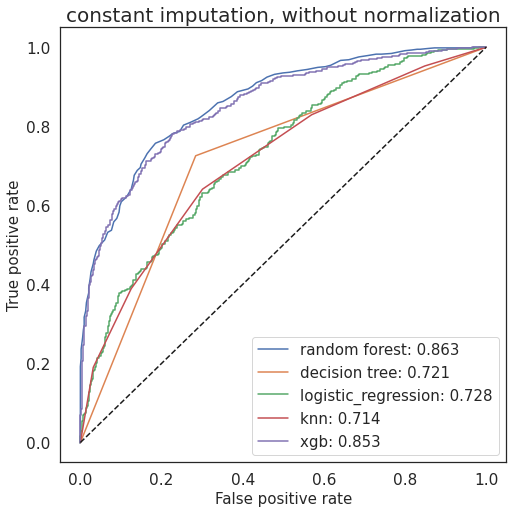

In [70]:
plot_roc_curves_for_mode_zoo()
plt.title("constant imputation, without normalization", fontsize=20)

In [71]:
#hospital independent normalization
data = data.set_index('Prognosis')
data = (data - data.mean())/data.std()
data = data.reset_index()

In [72]:
rf_preds   = model_selection.cross_val_predict(rf, data.drop(['Prognosis'], axis=1), 
                               data['Prognosis'], method='predict_proba', cv=10)
tree_preds   = model_selection.cross_val_predict(dt, data.drop(['Prognosis'], axis=1), 
                               data['Prognosis'], method='predict_proba', cv=10)
lr_preds   = model_selection.cross_val_predict(lr, data.drop(['Prognosis'], axis=1), 
                               data['Prognosis'], method='predict_proba', cv=10)
knn_preds   = model_selection.cross_val_predict(knn, data.drop(['Prognosis'], axis=1), 
                               data['Prognosis'], method='predict_proba', cv=10)
knn_preds   = model_selection.cross_val_predict(knn, data.drop(['Prognosis'], axis=1), 
                               data['Prognosis'], method='predict_proba', cv=10)
xgb_preds   = model_selection.cross_val_predict(xgb, data.drop(['Prognosis'], axis=1), 
                               data['Prognosis'], method='predict_proba', cv=10)

[15:18:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Text(0.5, 1.0, 'constant imputation, hospital independent normalization')

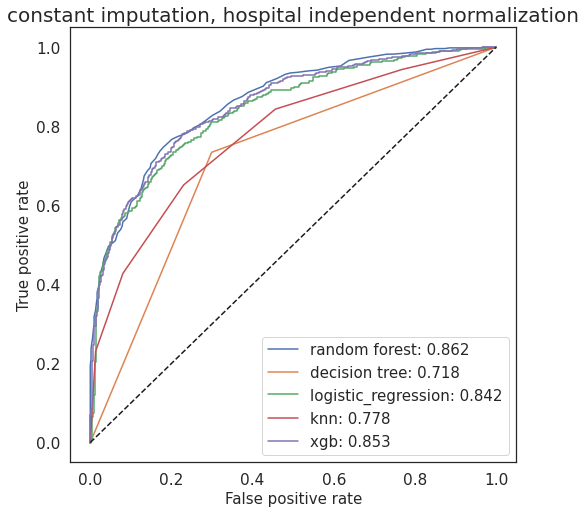

In [73]:
plot_roc_curves_for_mode_zoo()
plt.title("constant imputation, hospital independent normalization", fontsize=20)

#### 6.1.1 Xgb prediction, Imputing NaN values with a constant <a class="anchor" id="classification-611"></a>

In [74]:
xgb = XGBClassifier(n_estimators=100, max_depth=30, objective='binary:logistic', use_label_encoder=False)

In [75]:
# train test split
X_train, X_test, y_train, y_test = model_selection.train_test_split(data.drop('Prognosis', axis=1), data['Prognosis'], test_size=0.2, random_state=42)

In [76]:
xgb.fit(X_train, y_train)

[15:18:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=30, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=80,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [77]:
predictions = xgb.predict(X_test)

In [78]:
# model performance on training set

Text(0.5, 1.0, 'constant imputation, xgb, training set')

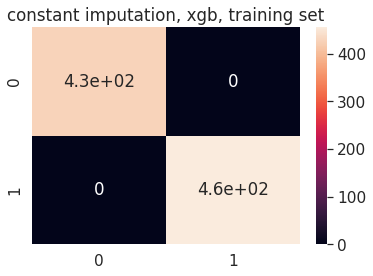

In [79]:
predictions_train = xgb.predict(X_train)
cm_train = metrics.confusion_matrix(y_train, predictions_train)
sns.heatmap(cm_train, annot=True)
plt.title('constant imputation, xgb, training set')

In [80]:
# model performance on test set

Text(0.5, 1.0, 'constant imputation, xgb, test set')

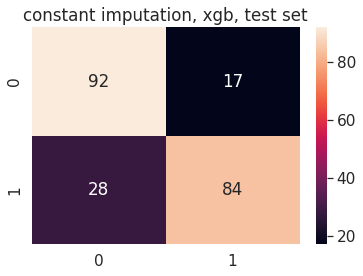

In [81]:
cm_test = metrics.confusion_matrix(y_test, predictions)
sns.heatmap(cm_test, annot=True)
plt.title('constant imputation, xgb, test set')

Text(0.5, 1.0, 'constant imputation, xgb, test set')

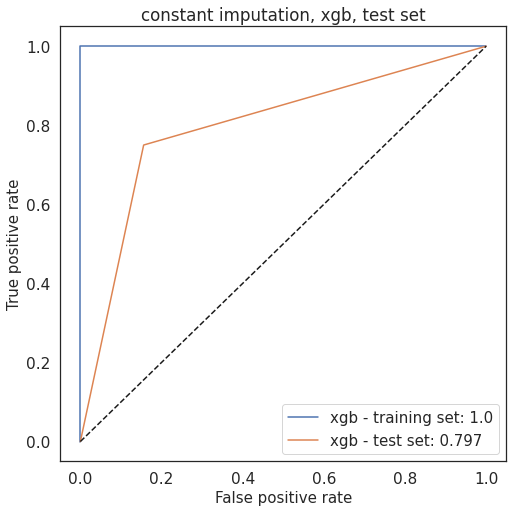

In [82]:
plt.figure(figsize=(8, 8))
for idx, preds in enumerate([predictions_train, predictions]):
    true_values=y_train if idx==0 else y_test
    fpr, tpr, _ = metrics.roc_curve(y_score=preds, y_true=true_values)
    auc = np.round(metrics.roc_auc_score(y_score=preds, y_true=true_values), 3)
    plt.plot(fpr, tpr, label=['xgb - training set', 'xgb - test set'][idx] + f': {auc}')
plt.legend(fontsize=15)
plt.plot([0, 1], [0, 1], '--', c='k')
plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate', fontsize=15)
plt.title('constant imputation, xgb, test set')

### 6.2 Imputing NaN values with random samples from columns <a class="anchor" id="classification-62"></a>

In [83]:
data = data_raw.copy()

In [84]:
# drop Fibrinogen, D_dimer, SaO2 columns as they have >60% missing value across the dataset

In [85]:
data.drop(['Fibrinogen', 'D_dimer', 'SaO2', 'PCT'], axis=1, inplace=True)

In [86]:
# drop rows that are 60% missing

In [87]:
keep_rows = data.isna().sum(1)[data.isna().sum(1) <= len(data.columns)*0.6].index.values
data = data[data.index.isin(keep_rows)]

<AxesSubplot:>

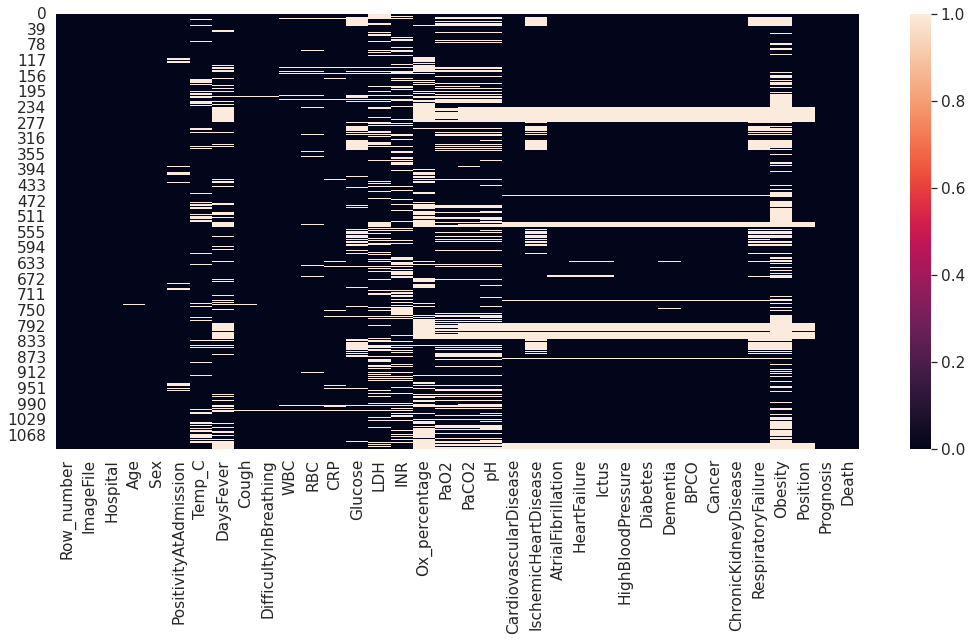

In [88]:
plt.figure(figsize=(18,8))
sns.set_style(style='white')
sns.heatmap(data.isna())

In [89]:
data_raw_grouped = data.groupby("Hospital")

miss_vals_afterdrop = []
for H in list(data_raw_grouped.groups.keys()):
    #print(f"{H}: {data_raw_grouped.get_group(H).isna().sum().sum()}")
    miss_vals_afterdrop.append(data_raw_grouped.get_group(H).isna().sum().sum())
    total += data_raw_grouped.get_group(H).isna().sum().sum()

df_miss_vals['Missing values after dropping rows/cols'] = miss_vals_afterdrop
df_miss_vals

Hospital  Missing values  Missing values after dropping rows/cols
0        A             600                                      180
1        B             297                                      158
2        C            2818                                     2145
3        D            1069                                      760
4        E             533                                      137
5        F            2812                                     1393

In [90]:
df_miss_vals_per_hospital_percent = pd.DataFrame()
for hospital in list(data_raw_grouped.groups.keys()):
    df_miss_vals_per_hospital_percent[hospital] = data_raw_grouped.get_group(hospital).isna().sum()
    

fig = px.histogram(df_miss_vals_per_hospital_percent, x=df_miss_vals_per_hospital_percent.index, y=df_miss_vals_per_hospital_percent.columns, \
                   labels= {'variable': 'Hospital'}, text_auto=True, )
fig.update_layout(
    title_text='Percentage of missing values per feature per hospital',
    xaxis_title_text='Feature Name',
    yaxis_title_text='Count',
    height=800,
    barmode="stack")
fig.update_xaxes(categoryorder='total descending')
fig.show()

In [91]:
data.head()

Row_number  ImageFile Hospital        Age  Sex  PositivityAtAdmission  \
0          82  P_102.png        A  72.000000    1                    1.0   
1         228  P_131.png        D  35.913889    0                    1.0   
2         229  P_132.png        D  57.266667    0                    1.0   
3          96  P_117.png        A  39.000000    1                    1.0   
4         112   P_16.png        A  44.000000    0                    1.0   

   Temp_C  DaysFever  Cough  DifficultyInBreathing  ...  Diabetes  Dementia  \
0    37.3        3.0    1.0                    0.0  ...       0.0       0.0   
1    39.3        3.0    1.0                    0.0  ...       0.0       0.0   
2    37.0        3.0    0.0                    0.0  ...       0.0       0.0   
3    37.2        2.0    1.0                    0.0  ...       0.0       0.0   
4    38.0        3.0    1.0                    0.0  ...       0.0       0.0   

   BPCO  Cancer  ChronicKidneyDisease  RespiratoryFailure  Obesity  Position  \
0   0.0     1.0                   0.0                 0.0      0.0       0.0   
1   0.0     0.0                   0.0                 NaN      1.0       0.0   
2   0.0     0.0                   0.0                 NaN      NaN       0.0   
3   0.0     0.0                   0.0                 0.0      0.0       1.0   
4   0.0     0.0                   0.0                 0.0      0.0       0.0   

   Prognosis  Death  
0     SEVERE      0  
1       MILD      0  
2       MILD      0  
3       MILD      0  
4     SEVERE      0  

[5 rows x 36 columns]

In [92]:
data["Prognosis"] = data["Prognosis"].apply(lambda x: 0 if x =='MILD' else 1)

hospitals = pd.get_dummies(data['Hospital'], prefix_sep='_', prefix='Hospital')
data = pd.concat([data, hospitals], axis=1)
data.drop('Hospital', axis=1, inplace=True)

data.drop(["Row_number", "ImageFile"], axis=1, inplace=True)

data = data.astype(float)

In [93]:
data.head()

Age  Sex  PositivityAtAdmission  Temp_C  DaysFever  Cough  \
0  72.000000  1.0                    1.0    37.3        3.0    1.0   
1  35.913889  0.0                    1.0    39.3        3.0    1.0   
2  57.266667  0.0                    1.0    37.0        3.0    0.0   
3  39.000000  1.0                    1.0    37.2        2.0    1.0   
4  44.000000  0.0                    1.0    38.0        3.0    1.0   

   DifficultyInBreathing    WBC   RBC    CRP  ...  Obesity  Position  \
0                    0.0   5.37  4.58   3.96  ...      0.0       0.0   
1                    0.0   5.76  5.24  43.40  ...      1.0       0.0   
2                    0.0  11.48  5.71  64.00  ...      NaN       0.0   
3                    0.0  10.17  3.45   0.75  ...      0.0       1.0   
4                    0.0   6.64  5.55   5.20  ...      0.0       0.0   

   Prognosis  Death  Hospital_A  Hospital_B  Hospital_C  Hospital_D  \
0        1.0    0.0         1.0         0.0         0.0         0.0   
1        0.0    0.0         0.0         0.0         0.0         1.0   
2        0.0    0.0         0.0         0.0         0.0         1.0   
3        0.0    0.0         1.0         0.0         0.0         0.0   
4        1.0    0.0         1.0         0.0         0.0         0.0   

   Hospital_E  Hospital_F  
0         0.0         0.0  
1         0.0         0.0  
2         0.0         0.0  
3         0.0         0.0  
4         0.0         0.0  

[5 rows x 39 columns]

In [94]:
# Impute missing values in columns based on random choices from non-missing values from a particular column

In [95]:
for idx, col_name in enumerate(data.columns.values):
        data[col_name] = data[col_name].fillna( pd.Series(data=np.random.choice(data[data[col_name].isna()==False][col_name], size=data[col_name].isna().sum()), index=data[data[col_name].isna()==True][col_name].index) )

In [96]:
data.isna().sum()

Age                      0
Sex                      0
PositivityAtAdmission    0
Temp_C                   0
DaysFever                0
Cough                    0
DifficultyInBreathing    0
WBC                      0
RBC                      0
CRP                      0
Glucose                  0
LDH                      0
INR                      0
Ox_percentage            0
PaO2                     0
PaCO2                    0
pH                       0
CardiovascularDisease    0
IschemicHeartDisease     0
AtrialFibrillation       0
HeartFailure             0
Ictus                    0
HighBloodPressure        0
Diabetes                 0
Dementia                 0
BPCO                     0
Cancer                   0
ChronicKidneyDisease     0
RespiratoryFailure       0
Obesity                  0
Position                 0
Prognosis                0
Death                    0
Hospital_A               0
Hospital_B               0
Hospital_C               0
Hospital_D               0
H

In [97]:
#hospital independent normalization
data = data.set_index('Prognosis')
data = (data - data.mean())/data.std()
data = data.reset_index()

In [98]:
kmeans = cluster.KMeans(n_clusters=2, random_state=42)
rf     = ensemble.RandomForestClassifier(random_state=42)
dt     = tree.DecisionTreeClassifier()
lr     = linear_model.LogisticRegression()
knn    = neighbors.KNeighborsClassifier(5)
xgb    = XGBClassifier(n_estimators=50, max_depth=3, objective='binary:logistic', use_label_encoder=False)

In [99]:
rf_preds   = model_selection.cross_val_predict(rf, data.drop(['Prognosis'], axis=1), 
                               data['Prognosis'], method='predict_proba', cv=10)
tree_preds   = model_selection.cross_val_predict(dt, data.drop(['Prognosis'], axis=1), 
                               data['Prognosis'], method='predict_proba', cv=10)
lr_preds   = model_selection.cross_val_predict(lr, data.drop(['Prognosis'], axis=1), 
                               data['Prognosis'], method='predict_proba', cv=10)
knn_preds   = model_selection.cross_val_predict(knn, data.drop(['Prognosis'], axis=1), 
                               data['Prognosis'], method='predict_proba', cv=10)
xgb_preds   = model_selection.cross_val_predict(xgb, data.drop(['Prognosis'], axis=1), 
                               data['Prognosis'], method='predict_proba', cv=10)

[15:18:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Text(0.5, 1.0, 'column based sampled imputation, hospital independent normalization')

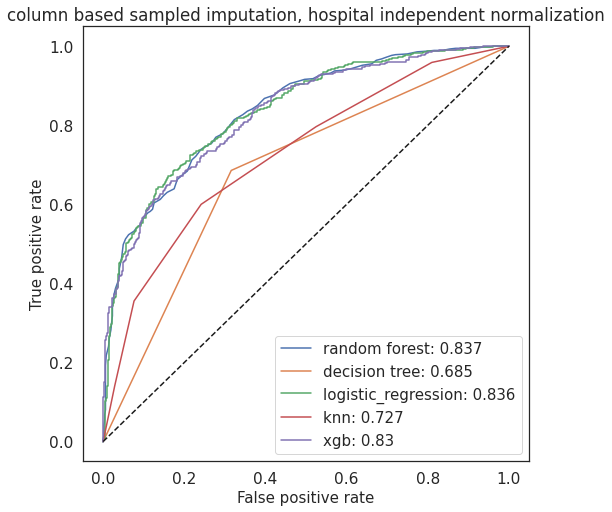

In [100]:
plot_roc_curves_for_mode_zoo()
plt.title('column based sampled imputation, hospital independent normalization')

## 7. Imputation functions <a class="anchor" id="imputationfunctions"></a>
### 7.1 Imputation functions  - population sampling <a class="anchor" id="imputationfunctions-71"></a>

In [101]:
def impute_sampling_from_population(train_data, test_data):
    """Impute missing values columnswise by random 
        sampling from the available data in the column.

    Args:
      train_data (DataFrame): Training dataset
      test_ data: (DataFrame) Test dataset
    Returns:
      test_data_imputed (DataFrame): Test data with NaN values imputed.
    """
    
    test_data_imputed = test_data.copy()
    
    # convert Hospital column to one-hot encoding
    hospitals = pd.get_dummies(test_data_imputed['Hospital'], prefix_sep='_', prefix='Hospital')
    test_data_imputed = pd.concat([test_data_imputed, hospitals], axis=1)
    test_data_imputed.drop('Hospital', axis=1, inplace=True)
    
    # drop unnecessary columns
    test_data_imputed.drop(["Row_number", "ImageFile"], axis=1, inplace=True)

    test_data_imputed = test_data_imputed.astype(float)
    
    # columnswise imputation
    for idx, col_name in enumerate(test_data_imputed.columns.values):
        imputation_data = np.random.choice(test_data_imputed[test_data_imputed[col_name].isna()==False][col_name],
                                           size=test_data_imputed[col_name].isna().sum())
        test_data_imputed[col_name] = test_data_imputed[col_name].fillna(pd.Series(data=imputation_data,
                                                                                   index=test_data_imputed[test_data_imputed[col_name].isna()==True][col_name].index))
        
    # standardization
    test_data_imputed = (test_data_imputed - test_data_imputed.mean())/test_data_imputed.std()

    return test_data_imputed

In [102]:
imputed_data = impute_sampling_from_population(train_data=data_raw, test_data=data_raw.drop(['Prognosis', 'Death'], axis=1))

In [103]:
imputed_data.shape

(1103, 41)

In [104]:
kmeans = cluster.KMeans(n_clusters=2, random_state=42)
rf     = ensemble.RandomForestClassifier(random_state=42)
dt     = tree.DecisionTreeClassifier()
lr     = linear_model.LogisticRegression()
knn    = neighbors.KNeighborsClassifier(5)
xgb    = XGBClassifier(n_estimators=50, max_depth=3, objective='binary:logistic', use_label_encoder=False)

In [105]:
rf_preds   = model_selection.cross_val_predict(rf, imputed_data, data_raw['Prognosis'], method='predict_proba', cv=10)
tree_preds = model_selection.cross_val_predict(dt, imputed_data, data_raw['Prognosis'], method='predict_proba', cv=10)
lr_preds   = model_selection.cross_val_predict(lr, imputed_data, data_raw['Prognosis'], method='predict_proba', cv=10)
knn_preds  = model_selection.cross_val_predict(knn, imputed_data, data_raw['Prognosis'], method='predict_proba', cv=10)
xgb_preds  = model_selection.cross_val_predict(xgb, imputed_data, data_raw['Prognosis'], method='predict_proba', cv=10)

[15:18:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Text(0.5, 1.0, 'Imputation function - population sampling')

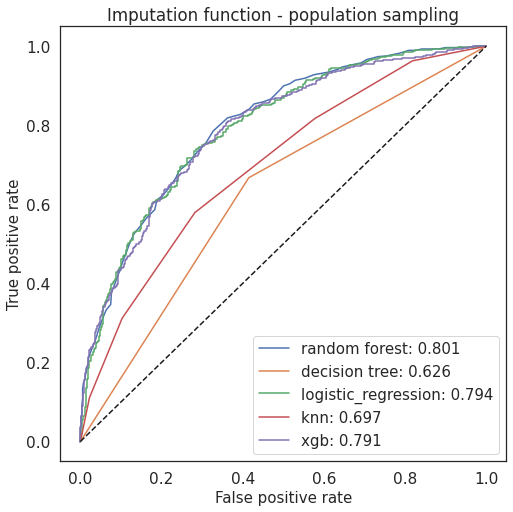

In [106]:
plt.figure(figsize=(8, 8))
for idx, preds in enumerate([rf_preds, tree_preds, lr_preds, knn_preds, xgb_preds]):
    fpr, tpr, _ = metrics.roc_curve(y_score=preds[:,1], y_true=data_raw['Prognosis'].apply(lambda x: 0 if x =='MILD' else 1))
    auc = np.round(metrics.roc_auc_score(y_score=preds[:,1], y_true=data_raw['Prognosis'].apply(lambda x: 0 if x =='MILD' else 1)), 3)
    plt.plot(fpr, tpr, label=['random forest', 'decision tree', 'logistic_regression', 'knn', 'xgb'][idx] + f': {auc}')
plt.legend(fontsize=15)
plt.plot([0, 1], [0, 1], '--', c='k')
plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate', fontsize=15)
plt.title('Imputation function - population sampling')

### 7.2 Imputation functions  - population average <a class="anchor" id="imputationfunctions-72"></a>

In [107]:
def impute_population_average(train_data, test_data):
    """Impute missing values columnswise by mean of the column.

    Args:
      train_data (DataFrame): Training dataset
      test_ data: (DataFrame) Test dataset
    Returns:
      test_data_imputed (DataFrame): Test data with NaN values imputed.
    """
    
    test_data_imputed = test_data.copy()

    # convert Hospital column to one-hot encoding
    hospitals = pd.get_dummies(test_data_imputed['Hospital'], prefix_sep='_', prefix='Hospital')
    test_data_imputed = pd.concat([test_data_imputed, hospitals], axis=1)
    test_data_imputed.drop('Hospital', axis=1, inplace=True)
    
    # drop unnecessary columns
    test_data_imputed.drop(["Row_number", "ImageFile"], axis=1, inplace=True)

    test_data_imputed = test_data_imputed.astype(float)
    
    # mean imputation
    for idx, col_name in enumerate(test_data_imputed.columns.values):
        imputation_data = test_data_imputed[col_name].mean()
        test_data_imputed[col_name] = test_data_imputed[col_name].fillna(imputation_data)
        
    # standardization
    test_data_imputed = (test_data_imputed - test_data_imputed.mean())/test_data_imputed.std()

    return test_data_imputed

In [108]:
imputed_data = impute_sampling_from_population(train_data=data_raw, test_data=data_raw.drop(['Prognosis', 'Death'], axis=1))

In [109]:
imputed_data.shape

(1103, 41)

In [110]:
kmeans = cluster.KMeans(n_clusters=2, random_state=42)
rf     = ensemble.RandomForestClassifier(random_state=42)
dt     = tree.DecisionTreeClassifier()
lr     = linear_model.LogisticRegression()
knn    = neighbors.KNeighborsClassifier(5)
xgb    = XGBClassifier(n_estimators=50, max_depth=3, objective='binary:logistic', use_label_encoder=False)

In [111]:
rf_preds   = model_selection.cross_val_predict(rf, imputed_data, data_raw['Prognosis'], method='predict_proba', cv=10)
tree_preds = model_selection.cross_val_predict(dt, imputed_data, data_raw['Prognosis'], method='predict_proba', cv=10)
lr_preds   = model_selection.cross_val_predict(lr, imputed_data, data_raw['Prognosis'], method='predict_proba', cv=10)
knn_preds  = model_selection.cross_val_predict(knn, imputed_data, data_raw['Prognosis'], method='predict_proba', cv=10)
xgb_preds  = model_selection.cross_val_predict(xgb, imputed_data, data_raw['Prognosis'], method='predict_proba', cv=10)

[15:18:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Text(0.5, 1.0, 'Imputation fucntion - population average')

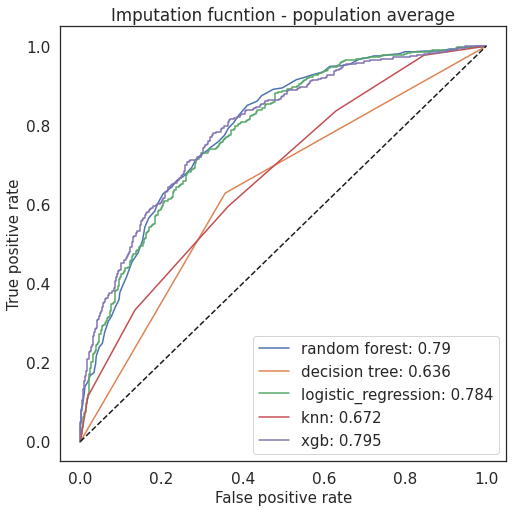

In [112]:
plt.figure(figsize=(8, 8))
for idx, preds in enumerate([rf_preds, tree_preds, lr_preds, knn_preds, xgb_preds]):
    fpr, tpr, _ = metrics.roc_curve(y_score=preds[:,1], y_true=data_raw['Prognosis'].apply(lambda x: 0 if x =='MILD' else 1))
    auc = np.round(metrics.roc_auc_score(y_score=preds[:,1], y_true=data_raw['Prognosis'].apply(lambda x: 0 if x =='MILD' else 1)), 3)
    plt.plot(fpr, tpr, label=['random forest', 'decision tree', 'logistic_regression', 'knn', 'xgb'][idx] + f': {auc}')
plt.legend(fontsize=15)
plt.plot([0, 1], [0, 1], '--', c='k')
plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate', fontsize=15)
plt.title('Imputation fucntion - population average')

## 8. Line by line imputation functions <a class="anchor" id="llimputationfunctions"></a>
### 8.1 Line by line imputation functions - population average <a class="anchor" id="llimputationfunctions-81"></a>

In [113]:
def line_impute_population_average(train_data, test_data_row):
    """Impute missing values in a row of test data based on mean, meadian
       value of the corresponding column in the training data.

    Args:
      train_data (DataFrame): Training dataset
      test_data_row: (DataFrame) A single row of the test dataset
    Returns:
      test_data_imputed (DataFrame): Test dataset with NaN values imputed.
    """
    
    # preprocessing of training dataset
    train_data_copy = train_data.copy()
    
    #train_data_copy.drop(['Prognosis', 'Death'], axis=1, inplace=True)
    
    hospitals = pd.get_dummies(train_data_copy['Hospital'], prefix_sep='_', prefix='Hospital')
    train_data_copy = pd.concat([train_data_copy, hospitals], axis=1)
    train_data_copy.drop(['Hospital', 'Row_number'], axis=1, inplace=True)
    
    #train_data_copy = train_data_copy.astype(float)

    
    # processing of test data
    test_data_row_imputed = test_data_row.copy()
    
    test_data_row_imputed = pd.concat([test_data_row_imputed.reset_index().drop('index', axis=1), 
                                       pd.DataFrame({'Hospital_A': [0], 'Hospital_B': [0], 'Hospital_C': [0], 'Hospital_D': [0], 'Hospital_E': [0], 'Hospital_F': [0]})], axis=1)

    test_data_row_imputed['Hospital_{}'.format(test_data_row_imputed['Hospital'].values[0])] = 1
    test_data_row_imputed.drop(['Hospital', 'Row_number'], axis=1, inplace=True)

    #test_data_row_imputed = test_data_row_imputed.astype(float)

    # imputation
    continuous_features = ["Age","Temp_C","DaysFever","WBC","RBC","CRP","Fibrinogen","Glucose","PCT","LDH","INR","D_dimer","Ox_percentage","PaO2","SaO2","PaCO2","pH"]
    discrete_features = ["Sex","PositivityAtAdmission","Cough","DifficultyInBreathing","CardiovascularDisease","IschemicHeartDisease","AtrialFibrillation","HeartFailure",
                         "Ictus","HighBloodPressure","Diabetes","Dementia","BPCO","Cancer","ChronicKidneyDisease","RespiratoryFailure","Obesity","Position"]

    for idx, col_name in enumerate(test_data_row_imputed.columns.values):
        if test_data_row_imputed[col_name].isnull().values.any():
            if col_name in continuous_features:
                test_data_row_imputed[col_name] = train_data_copy[col_name].dropna().mean()
            elif col_name in discrete_features:
                test_data_row_imputed[col_name] = train_data_copy[col_name].dropna().median()
    
    
    test_data_row_imputed[continuous_features] = (test_data_row_imputed[continuous_features] - train_data_copy[continuous_features].mean())/train_data_copy[continuous_features].std()
    
    
    return test_data_row_imputed

In [114]:
# generate data line by line

In [116]:
imputed_data = pd.DataFrame()

for idx in range(len(data_raw)):
    imputed_data_row = line_impute_population_average(train_data=data_raw, test_data_row=data_raw.iloc[[idx]])
    imputed_data = pd.concat([imputed_data, imputed_data_row], axis=0)
imputed_data = imputed_data.reset_index().drop('index', axis=1)

In [131]:
data_raw.shape, imputed_data.shape

((1103, 40), (1103, 44))

In [118]:
test_data = pd.read_excel('../data/raw_data/testClinData.xls')

In [120]:
imputed_test_data = pd.DataFrame()

for idx in range(len(test_data)):
    imputed_test_data_row = line_impute_population_average(train_data=data_raw, test_data_row=test_data.iloc[[idx]])
    imputed_test_data = pd.concat([imputed_test_data, imputed_test_data_row], axis=0)
imputed_test_data = imputed_test_data.reset_index().drop('index', axis=1)

In [132]:
test_data.shape, imputed_test_data.shape

((486, 40), (486, 44))

In [122]:
# Save imputed training and test data

In [123]:
#imputed_data.to_csv('../data/preprocessed_data/trainClinDataImputedPopAvg.csv', index=False)

In [124]:
#imputed_test_data.to_csv('../data/preprocessed_data/tables/pop_avg/testClinDataImputedPopAvg.csv', index=False)

In [125]:
kmeans = cluster.KMeans(n_clusters=2, random_state=42)
rf     = ensemble.RandomForestClassifier(random_state=42)
dt     = tree.DecisionTreeClassifier()
lr     = linear_model.LogisticRegression()
knn    = neighbors.KNeighborsClassifier(5)
xgb    = XGBClassifier(n_estimators=50, max_depth=3, objective='binary:logistic', use_label_encoder=False)

In [126]:
cols_top_drop = ['Prognosis', 'Death', 'ImageFile']
rf_preds   = model_selection.cross_val_predict(rf, imputed_data.drop(cols_top_drop, axis=1), data_raw['Prognosis'], method='predict_proba', cv=10)
tree_preds = model_selection.cross_val_predict(dt, imputed_data.drop(cols_top_drop, axis=1), data_raw['Prognosis'], method='predict_proba', cv=10)
lr_preds   = model_selection.cross_val_predict(lr, imputed_data.drop(cols_top_drop, axis=1), data_raw['Prognosis'], method='predict_proba', cv=10)
knn_preds  = model_selection.cross_val_predict(knn, imputed_data.drop(cols_top_drop, axis=1), data_raw['Prognosis'], method='predict_proba', cv=10)
xgb_preds  = model_selection.cross_val_predict(xgb, imputed_data.drop(cols_top_drop, axis=1), data_raw['Prognosis'], method='predict_proba', cv=10)

[15:18:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Text(0.5, 1.0, 'Imputation fucntion - population average')

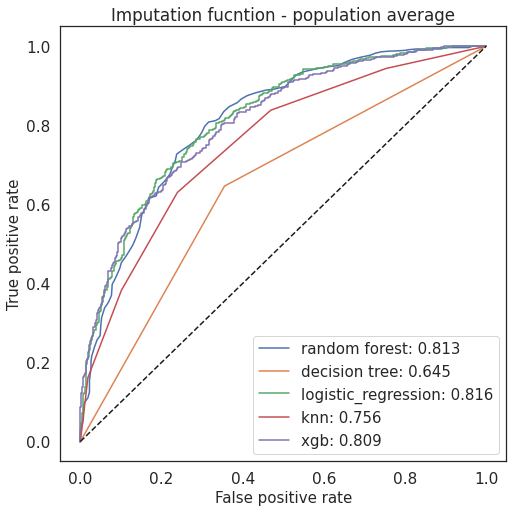

In [127]:
plt.figure(figsize=(8, 8))
for idx, preds in enumerate([rf_preds, tree_preds, lr_preds, knn_preds, xgb_preds]):
    fpr, tpr, _ = metrics.roc_curve(y_score=preds[:,1], y_true=data_raw['Prognosis'].apply(lambda x: 0 if x =='MILD' else 1))
    auc = np.round(metrics.roc_auc_score(y_score=preds[:,1], y_true=data_raw['Prognosis'].apply(lambda x: 0 if x =='MILD' else 1)), 3)
    plt.plot(fpr, tpr, label=['random forest', 'decision tree', 'logistic_regression', 'knn', 'xgb'][idx] + f': {auc}')
plt.legend(fontsize=15)
plt.plot([0, 1], [0, 1], '--', c='k')
plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate', fontsize=15)
plt.title('Line by line imputation fucntion - population average')

### 8.2 Line by line imputation functions - population sampling <a class="anchor" id="llimputationfunctions-82"></a>

In [6]:
def line_impute_population_sampling(train_data, test_data_row):
    """Impute missing values in a row of test data based on random
        sampling from the available values in the corresponding column in the training data.

    Args:
      train_data (DataFrame): Training dataset
      test_data_row: (DataFrame) A single row of the test dataset
    Returns:
      test_data_imputed (DataFrame): Test dataset with NaN values imputed.
    """
    
    # preprocessing of training dataset
    train_data_copy = train_data.copy()
    
    #train_data_copy.drop(['Prognosis', 'Death'], axis=1, inplace=True)
    
    hospitals = pd.get_dummies(train_data_copy['Hospital'], prefix_sep='_', prefix='Hospital')
    train_data_copy = pd.concat([train_data_copy, hospitals], axis=1)
    train_data_copy.drop(['Hospital', 'Row_number'], axis=1, inplace=True)
    
    #train_data_copy = train_data_copy.astype(float)

    
    # processing of test data
    test_data_row_imputed = test_data_row.copy()
    
    test_data_row_imputed = pd.concat([test_data_row_imputed.reset_index().drop('index', axis=1), 
                                       pd.DataFrame({'Hospital_A': [0], 'Hospital_B': [0], 'Hospital_C': [0], 'Hospital_D': [0], 'Hospital_E': [0], 'Hospital_F': [0]})], axis=1)

    test_data_row_imputed['Hospital_{}'.format(test_data_row_imputed['Hospital'].values[0])] = 1
    test_data_row_imputed.drop(['Hospital', 'Row_number'], axis=1, inplace=True)

    #test_data_row_imputed = test_data_row_imputed.astype(float)

    # imputation
    continuous_features = ["Age","Temp_C","DaysFever","WBC","RBC","CRP","Fibrinogen","Glucose","PCT","LDH","INR","D_dimer","Ox_percentage","PaO2","SaO2","PaCO2","pH"]
    discrete_features = ["Sex","PositivityAtAdmission","Cough","DifficultyInBreathing","CardiovascularDisease","IschemicHeartDisease","AtrialFibrillation","HeartFailure",
                         "Ictus","HighBloodPressure","Diabetes","Dementia","BPCO","Cancer","ChronicKidneyDisease","RespiratoryFailure","Obesity","Position"]

    for idx, col_name in enumerate(test_data_row_imputed.columns.values):
        if test_data_row_imputed[col_name].isnull().values.any():
            if col_name in continuous_features or col_name in discrete_features:
                
                imputation_data = np.random.choice(train_data_copy[col_name].dropna())
                
                test_data_row_imputed[col_name] = imputation_data
    
    
    test_data_row_imputed[continuous_features] = (test_data_row_imputed[continuous_features] - train_data_copy[continuous_features].mean())/train_data_copy[continuous_features].std()
    
    
    return test_data_row_imputed

In [151]:
# generate data line by line

In [7]:
data_raw = pd.read_excel('../data/raw_data/trainClinData.xls')

In [8]:
imputed_data_sampled = pd.DataFrame()

for idx in range(len(data_raw)):
    imputed_data_sampled_row = line_impute_population_sampling(train_data=data_raw, test_data_row=data_raw.iloc[[idx]])
    imputed_data_sampled = pd.concat([imputed_data_sampled, imputed_data_sampled_row], axis=0)
imputed_data_sampled = imputed_data_sampled.reset_index().drop('index', axis=1)

In [9]:
data_raw.shape, imputed_data_sampled.shape

((1103, 40), (1103, 44))

In [168]:
test_data = pd.read_excel('../data/raw_data/testClinData.xls')

In [169]:
imputed_test_data_sampled = pd.DataFrame()

for idx in range(len(test_data)):
    imputed_test_data_sampled_row = line_impute_population_sampling(train_data=data_raw, test_data_row=test_data.iloc[[idx]])
    imputed_test_data_sampled = pd.concat([imputed_test_data_sampled, imputed_test_data_sampled_row], axis=0)
imputed_test_data_sampled = imputed_test_data_sampled.reset_index().drop('index', axis=1)

In [201]:
test_data.shape, imputed_test_data_sampled.shape

((486, 40), (486, 44))

In [199]:
# Save imputed training and test data

In [185]:
#imputed_data_sampled.to_csv('../data/preprocessed_data/trainClinDataImputedRandSampled.csv', index=False)

In [187]:
#imputed_test_data_sampled.to_csv('../data/preprocessed_data/testClinDataImputedRandSampled.csv', index=False)

In [202]:
kmeans = cluster.KMeans(n_clusters=2, random_state=42)
rf     = ensemble.RandomForestClassifier(random_state=42)
dt     = tree.DecisionTreeClassifier()
lr     = linear_model.LogisticRegression()
knn    = neighbors.KNeighborsClassifier(5)
xgb    = XGBClassifier(n_estimators=50, max_depth=3, objective='binary:logistic', use_label_encoder=False)

In [203]:
cols_top_drop = ['Prognosis', 'Death', 'ImageFile']
rf_preds   = model_selection.cross_val_predict(rf, imputed_data_sampled.drop(cols_top_drop, axis=1), data_raw['Prognosis'], method='predict_proba', cv=10)
tree_preds = model_selection.cross_val_predict(dt, imputed_data_sampled.drop(cols_top_drop, axis=1), data_raw['Prognosis'], method='predict_proba', cv=10)
lr_preds   = model_selection.cross_val_predict(lr, imputed_data_sampled.drop(cols_top_drop, axis=1), data_raw['Prognosis'], method='predict_proba', cv=10)
knn_preds  = model_selection.cross_val_predict(knn, imputed_data_sampled.drop(cols_top_drop, axis=1), data_raw['Prognosis'], method='predict_proba', cv=10)
xgb_preds  = model_selection.cross_val_predict(xgb, imputed_data_sampled.drop(cols_top_drop, axis=1), data_raw['Prognosis'], method='predict_proba', cv=10)

[16:25:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:25:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:25:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:25:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Text(0.5, 1.0, 'Line by line imputation fucntion - population sampling')

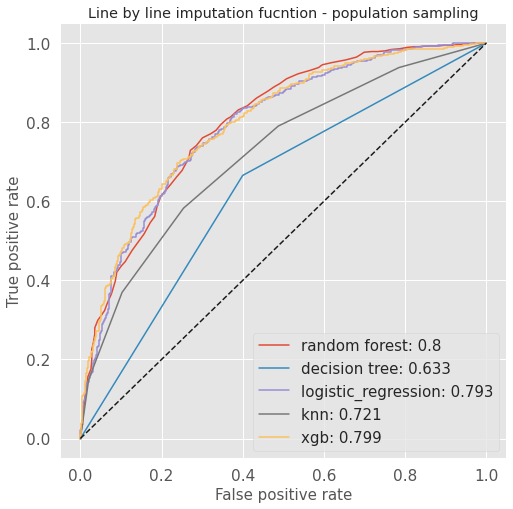

In [204]:
plt.figure(figsize=(8, 8))
for idx, preds in enumerate([rf_preds, tree_preds, lr_preds, knn_preds, xgb_preds]):
    fpr, tpr, _ = metrics.roc_curve(y_score=preds[:,1], y_true=data_raw['Prognosis'].apply(lambda x: 0 if x =='MILD' else 1))
    auc = np.round(metrics.roc_auc_score(y_score=preds[:,1], y_true=data_raw['Prognosis'].apply(lambda x: 0 if x =='MILD' else 1)), 3)
    plt.plot(fpr, tpr, label=['random forest', 'decision tree', 'logistic_regression', 'knn', 'xgb'][idx] + f': {auc}')
plt.legend(fontsize=15)
plt.plot([0, 1], [0, 1], '--', c='k')
plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate', fontsize=15)
plt.title('Line by line imputation fucntion - population sampling')

### 8.3 Line by line imputation functions - age average <a class="anchor" id="llimputationfunctions-83"></a>

In [237]:
def line_impute_age_average(train_data, test_data_row):
    """Impute missing values in a row of test data based on average of k nearest neighbors in age.

    Args:
      train_data (DataFrame): Training dataset
      test_data_row: (DataFrame) A single row of the test dataset
    Returns:
      test_data_imputed (DataFrame): Test dataset with NaN values imputed.
    """
    
    # preprocessing of training dataset
    train_data_copy = train_data.copy()
    
    hospitals = pd.get_dummies(train_data_copy['Hospital'], prefix_sep='_', prefix='Hospital')
    train_data_copy = pd.concat([train_data_copy, hospitals], axis=1)
    train_data_copy.drop(['Hospital', 'Row_number'], axis=1, inplace=True)

    
    # processing of test data
    test_data_row_imputed = test_data_row.copy()
    
    test_data_row_imputed = pd.concat([test_data_row_imputed.reset_index().drop('index', axis=1), 
                                       pd.DataFrame({'Hospital_A': [0], 'Hospital_B': [0], 'Hospital_C': [0], 'Hospital_D': [0], 'Hospital_E': [0], 'Hospital_F': [0]})], axis=1)

    test_data_row_imputed['Hospital_{}'.format(test_data_row_imputed['Hospital'].values[0])] = 1
    test_data_row_imputed.drop(['Hospital', 'Row_number'], axis=1, inplace=True)


    # imputation
    continuous_features = ["Age","Temp_C","DaysFever","WBC","RBC","CRP","Fibrinogen","Glucose","PCT","LDH","INR","D_dimer","Ox_percentage","PaO2","SaO2","PaCO2","pH"]
    discrete_features = ["Sex","PositivityAtAdmission","Cough","DifficultyInBreathing","CardiovascularDisease","IschemicHeartDisease","AtrialFibrillation","HeartFailure",
                         "Ictus","HighBloodPressure","Diabetes","Dementia","BPCO","Cancer","ChronicKidneyDisease","RespiratoryFailure","Obesity","Position"]
                
    for idx, col_name in enumerate(test_data_row_imputed.columns.values):
        
        if test_data_row_imputed[col_name].isnull().values.any():
            
            if col_name == 'Age':
                test_data_row_imputed[col_name] = train_data_copy[col_name].dropna().mean()
            if col_name == 'PCT':
                test_data_row_imputed[col_name] = np.random.choice(train_data_copy[col_name].dropna())
            else:
                distances = abs(train_data_copy['Age'] - test_data_row_imputed['Age']).sort_values().index.values[:10]

                if col_name in continuous_features:          
                    test_data_row_imputed[col_name] = np.mean(train_data_copy[train_data_copy.index.isin(distances)][col_name].dropna())     
                elif col_name in discrete_features:
                    test_data_row_imputed[col_name] = np.median(train_data_copy[train_data_copy.index.isin(distances)][col_name].dropna())
    
    
    test_data_row_imputed[continuous_features] = (test_data_row_imputed[continuous_features] - train_data_copy[continuous_features].mean())/train_data_copy[continuous_features].std()
    
    
    return test_data_row_imputed

In [224]:
# generate data line by line

In [238]:
data_raw = pd.read_excel('../data/raw_data/trainClinData.xls')

In [239]:
imputed_data_age_average = pd.DataFrame()

for idx in range(len(data_raw)):
    imputed_data_age_average_row = line_impute_age_average(train_data=data_raw, test_data_row=data_raw.iloc[[idx]])
    imputed_data_age_average = pd.concat([imputed_data_age_average, imputed_data_age_average_row], axis=0)
imputed_data_age_average = imputed_data_age_average.reset_index().drop('index', axis=1)

In [227]:
data_raw.shape, imputed_data_age_average.shape

((1103, 40), (1103, 44))

In [228]:
test_data = pd.read_excel('../data/raw_data/testClinData.xls')

In [229]:
imputed_test_data_age_average = pd.DataFrame()

for idx in range(len(test_data)):
    imputed_test_data_age_average_row = line_impute_age_average(train_data=data_raw, test_data_row=test_data.iloc[[idx]])
    imputed_test_data_age_average = pd.concat([imputed_test_data_age_average, imputed_test_data_age_average_row], axis=0)
imputed_test_data_age_average = imputed_test_data_age_average.reset_index().drop('index', axis=1)

In [230]:
test_data.shape, imputed_test_data_age_average.shape

((486, 40), (486, 44))

In [231]:
# save imputed train and test data

In [232]:
#imputed_data_age_average.to_csv('../data/preprocessed_data/trainClinDataImputedAgeAvg.csv', index=False)

In [233]:
#imputed_test_data_age_average.to_csv('../data/preprocessed_data/testClinDataImputedAgeAvg.csv', index=False)

In [240]:
kmeans = cluster.KMeans(n_clusters=2, random_state=42)
rf     = ensemble.RandomForestClassifier(random_state=42)
dt     = tree.DecisionTreeClassifier()
lr     = linear_model.LogisticRegression()
knn    = neighbors.KNeighborsClassifier(5)
xgb    = XGBClassifier(n_estimators=50, max_depth=3, objective='binary:logistic', use_label_encoder=False)

In [241]:
cols_top_drop = ['Prognosis', 'Death', 'ImageFile']
rf_preds   = model_selection.cross_val_predict(rf, imputed_data_age_average.drop(cols_top_drop, axis=1), data_raw['Prognosis'], method='predict_proba', cv=10, )
tree_preds = model_selection.cross_val_predict(dt, imputed_data_age_average.drop(cols_top_drop, axis=1), data_raw['Prognosis'], method='predict_proba', cv=10)
lr_preds   = model_selection.cross_val_predict(lr, imputed_data_age_average.drop(cols_top_drop, axis=1), data_raw['Prognosis'], method='predict_proba', cv=10)
knn_preds  = model_selection.cross_val_predict(knn, imputed_data_age_average.drop(cols_top_drop, axis=1), data_raw['Prognosis'], method='predict_proba', cv=10)
xgb_preds  = model_selection.cross_val_predict(xgb, imputed_data_age_average.drop(cols_top_drop, axis=1), data_raw['Prognosis'], method='predict_proba', cv=10)

[17:26:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:26:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:26:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:26:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Text(0.5, 1.0, 'Line by line imputation fucntion - age average')

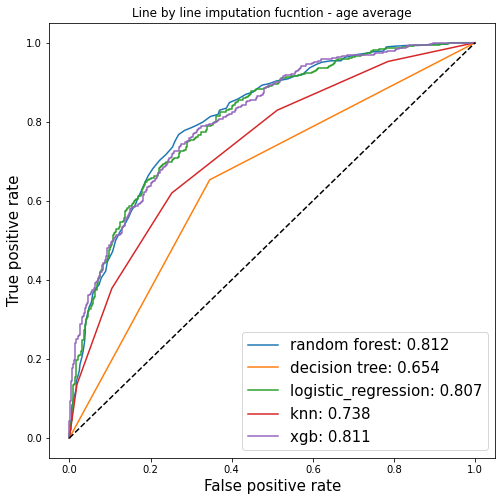

In [243]:
plt.figure(figsize=(8, 8))
for idx, preds in enumerate([rf_preds, tree_preds, lr_preds, knn_preds, xgb_preds]):
    fpr, tpr, _ = metrics.roc_curve(y_score=preds[:,1], y_true=data_raw['Prognosis'].apply(lambda x: 0 if x =='MILD' else 1))
    auc = np.round(metrics.roc_auc_score(y_score=preds[:,1], y_true=data_raw['Prognosis'].apply(lambda x: 0 if x =='MILD' else 1)), 3)
    plt.plot(fpr, tpr, label=['random forest', 'decision tree', 'logistic_regression', 'knn', 'xgb'][idx] + f': {auc}')
plt.legend(fontsize=15)
plt.plot([0, 1], [0, 1], '--', c='k')
plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate', fontsize=15)
plt.title('Line by line imputation fucntion - age average')

### 8.4 Line by line imputation functions - hospital average <a class="anchor" id="llimputationfunctions-84"></a>

In [112]:
def line_impute_hospital_average(train_data, test_data_row):
    """Impute missing values in a row of test data based on average from patients in the same hospital.

    Args:
      train_data (DataFrame): Training dataset
      test_data_row: (DataFrame) A single row of the test dataset
    Returns:
      test_data_imputed (DataFrame): Test dataset with NaN values imputed.
    """
    
    # preprocessing of training dataset
    train_data_copy = train_data.copy()
    
    hospitals = pd.get_dummies(train_data_copy['Hospital'], prefix_sep='_', prefix='Hospital')
    train_data_copy = pd.concat([train_data_copy, hospitals], axis=1)
    train_data_copy.drop(['Row_number'], axis=1, inplace=True)

    
    # processing of test data
    test_data_row_imputed = test_data_row.copy()
    
    test_data_row_imputed = pd.concat([test_data_row_imputed.reset_index().drop('index', axis=1), 
                                       pd.DataFrame({'Hospital_A': [0], 'Hospital_B': [0], 'Hospital_C': [0], 'Hospital_D': [0], 'Hospital_E': [0], 'Hospital_F': [0]})], axis=1)

    test_data_row_imputed['Hospital_{}'.format(test_data_row_imputed['Hospital'].values[0])] = 1
    test_data_row_imputed.drop(['Row_number'], axis=1, inplace=True)


    # imputation
    continuous_features = ["Age","Temp_C","DaysFever","WBC","RBC","CRP","Fibrinogen","Glucose","PCT","LDH","INR","D_dimer","Ox_percentage","PaO2","SaO2","PaCO2","pH"]
    discrete_features = ["Sex","PositivityAtAdmission","Cough","DifficultyInBreathing","CardiovascularDisease","IschemicHeartDisease","AtrialFibrillation","HeartFailure",
                         "Ictus","HighBloodPressure","Diabetes","Dementia","BPCO","Cancer","ChronicKidneyDisease","RespiratoryFailure","Obesity","Position"]
                
    for idx, col_name in enumerate(test_data_row_imputed.columns.values):
        
        if test_data_row_imputed[col_name].isnull().values.any():
            
            
            indexes = train_data_copy[train_data_copy['Hospital'] == test_data_row_imputed['Hospital'][0]].index.values

            if col_name in continuous_features:
                imputed_value = np.mean(train_data_copy[train_data_copy.index.isin(indexes)][col_name].dropna())
                test_data_row_imputed[col_name] =  imputed_value if not math.isnan(imputed_value) else np.random.choice(train_data_copy[col_name].dropna())
            elif col_name in discrete_features:
                imputed_value =  np.median(train_data_copy[train_data_copy.index.isin(indexes)][col_name].dropna())
                test_data_row_imputed[col_name] = imputed_value if not math.isnan(imputed_value) else np.random.choice(train_data_copy[col_name].dropna())
    
    
    test_data_row_imputed[continuous_features] = (test_data_row_imputed[continuous_features] - train_data_copy[continuous_features].mean())/train_data_copy[continuous_features].std()
    test_data_row_imputed.drop(['Hospital'], axis=1, inplace=True)
    
    
    return test_data_row_imputed

In [113]:
# generate data line by line

In [114]:
data_raw = pd.read_excel('../data/raw_data/trainClinData.xls')

In [115]:
imputed_data_hospital_average = pd.DataFrame()

for idx in range(len(data_raw)):
    imputed_data_hospital_average_row = line_impute_hospital_average(train_data=data_raw, test_data_row=data_raw.iloc[[idx]])
    imputed_data_hospital_average = pd.concat([imputed_data_hospital_average, imputed_data_hospital_average_row], axis=0)
imputed_data_hospital_average = imputed_data_hospital_average.reset_index().drop('index', axis=1)

In [129]:
data_raw.shape, imputed_data_hospital_average.shape

((1103, 40), (1103, 44))

In [131]:
test_data = pd.read_excel('../data/raw_data/testClinData.xls')

In [132]:
imputed_test_data_hospital_average = pd.DataFrame()

for idx in range(len(test_data)):
    imputed_test_data_hospital_average_row = line_impute_hospital_average(train_data=data_raw, test_data_row=test_data.iloc[[idx]])
    imputed_test_data_hospital_average = pd.concat([imputed_test_data_hospital_average, imputed_test_data_hospital_average_row], axis=0)
imputed_test_data_hospital_average = imputed_test_data_hospital_average.reset_index().drop('index', axis=1)

In [133]:
test_data.shape, imputed_test_data_hospital_average.shape

((486, 40), (486, 44))

In [143]:
# save imputed trian and test data

In [144]:
#imputed_data_hospital_average.to_csv('../data/preprocessed_data/trainClinDataImputedHospAvg.csv', index=False)

In [148]:
#imputed_test_data_hospital_average.to_csv('../data/preprocessed_data/testClinDataImputedHospAvg.csv', index=False)

In [124]:
kmeans = cluster.KMeans(n_clusters=2, random_state=42)
rf     = ensemble.RandomForestClassifier(random_state=42)
dt     = tree.DecisionTreeClassifier()
lr     = linear_model.LogisticRegression()
knn    = neighbors.KNeighborsClassifier(5)
xgb    = XGBClassifier(n_estimators=50, max_depth=3, objective='binary:logistic', use_label_encoder=False)

In [127]:
cols_top_drop = ['Prognosis', 'Death', 'ImageFile']
rf_preds   = model_selection.cross_val_predict(rf, imputed_data_hospital_average.drop(cols_top_drop, axis=1), data_raw['Prognosis'], method='predict_proba', cv=10)
tree_preds = model_selection.cross_val_predict(dt, imputed_data_hospital_average.drop(cols_top_drop, axis=1), data_raw['Prognosis'], method='predict_proba', cv=10)
lr_preds   = model_selection.cross_val_predict(lr, imputed_data_hospital_average.drop(cols_top_drop, axis=1), data_raw['Prognosis'], method='predict_proba', cv=10)
knn_preds  = model_selection.cross_val_predict(knn, imputed_data_hospital_average.drop(cols_top_drop, axis=1), data_raw['Prognosis'], method='predict_proba', cv=10)
xgb_preds  = model_selection.cross_val_predict(xgb, imputed_data_hospital_average.drop(cols_top_drop, axis=1), data_raw['Prognosis'], method='predict_proba', cv=10)

[14:40:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:40:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:40:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:41:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Text(0.5, 1.0, 'Line by line imputation fucntion - hospital average')

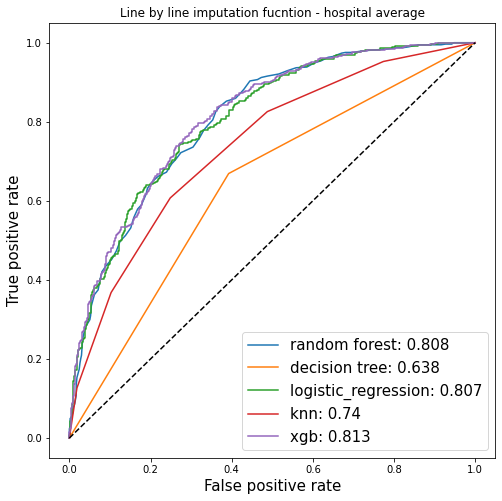

In [128]:
plt.figure(figsize=(8, 8))
for idx, preds in enumerate([rf_preds, tree_preds, lr_preds, knn_preds, xgb_preds]):
    fpr, tpr, _ = metrics.roc_curve(y_score=preds[:,1], y_true=data_raw['Prognosis'].apply(lambda x: 0 if x =='MILD' else 1))
    auc = np.round(metrics.roc_auc_score(y_score=preds[:,1], y_true=data_raw['Prognosis'].apply(lambda x: 0 if x =='MILD' else 1)), 3)
    plt.plot(fpr, tpr, label=['random forest', 'decision tree', 'logistic_regression', 'knn', 'xgb'][idx] + f': {auc}')
plt.legend(fontsize=15)
plt.plot([0, 1], [0, 1], '--', c='k')
plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate', fontsize=15)
plt.title('Line by line imputation fucntion - hospital average')

### 8.5 Line by line imputation functions - hospital sampling <a class="anchor" id="llimputationfunctions-85"></a>

In [172]:
def line_impute_hospital_sampling(train_data, test_data_row):
    """Impute missing values in a row of test data based on random sample from patients in the same hospital.

    Args:
      train_data (DataFrame): Training dataset
      test_data_row: (DataFrame) A single row of the test dataset
    Returns:
      test_data_imputed (DataFrame): Test dataset with NaN values imputed.
    """
    
    # preprocessing of training dataset
    train_data_copy = train_data.copy()
    
    hospitals = pd.get_dummies(train_data_copy['Hospital'], prefix_sep='_', prefix='Hospital')
    train_data_copy = pd.concat([train_data_copy, hospitals], axis=1)
    train_data_copy.drop(['Row_number'], axis=1, inplace=True)

    
    # processing of test data
    test_data_row_imputed = test_data_row.copy()
    
    test_data_row_imputed = pd.concat([test_data_row_imputed.reset_index().drop('index', axis=1), 
                                       pd.DataFrame({'Hospital_A': [0], 'Hospital_B': [0], 'Hospital_C': [0], 'Hospital_D': [0], 'Hospital_E': [0], 'Hospital_F': [0]})], axis=1)

    test_data_row_imputed['Hospital_{}'.format(test_data_row_imputed['Hospital'].values[0])] = 1
    test_data_row_imputed.drop(['Row_number'], axis=1, inplace=True)


    # imputation
    continuous_features = ["Age","Temp_C","DaysFever","WBC","RBC","CRP","Fibrinogen","Glucose","PCT","LDH","INR","D_dimer","Ox_percentage","PaO2","SaO2","PaCO2","pH"]
    discrete_features = ["Sex","PositivityAtAdmission","Cough","DifficultyInBreathing","CardiovascularDisease","IschemicHeartDisease","AtrialFibrillation","HeartFailure",
                         "Ictus","HighBloodPressure","Diabetes","Dementia","BPCO","Cancer","ChronicKidneyDisease","RespiratoryFailure","Obesity","Position"]
                
    for idx, col_name in enumerate(test_data_row_imputed.columns.values):
        
        if test_data_row_imputed[col_name].isnull().values.any():
            
            indexes = train_data_copy[train_data_copy['Hospital'] == test_data_row_imputed['Hospital'][0]].index.values

            if col_name in continuous_features or col_name in discrete_features:
                
                if not train_data_copy[train_data_copy.index.isin(indexes)][col_name].dropna().isna().all:
                    
                    imputed_value = np.random.choice(train_data_copy[train_data_copy.index.isin(indexes)][col_name].dropna())
                else:
                    imputed_value = np.random.choice(train_data_copy[col_name].dropna())
                    
                test_data_row_imputed[col_name] =  imputed_value
    
    
    test_data_row_imputed[continuous_features] = (test_data_row_imputed[continuous_features] - train_data_copy[continuous_features].mean())/train_data_copy[continuous_features].std()
    test_data_row_imputed.drop(['Hospital'], axis=1, inplace=True)
    
    
    return test_data_row_imputed

In [167]:
# generate data line by line

In [188]:
data_raw = pd.read_excel('../data/raw_data/trainClinData.xls')

In [189]:
imputed_data_hospital_sample = pd.DataFrame()

for idx in range(len(data_raw)):
    imputed_data_hospital_sample_row = line_impute_hospital_sampling(train_data=data_raw, test_data_row=data_raw.iloc[[idx]])
    imputed_data_hospital_sample = pd.concat([imputed_data_hospital_sample, imputed_data_hospital_sample_row], axis=0)
imputed_data_hospital_sample = imputed_data_hospital_sample.reset_index().drop('index', axis=1)

In [199]:
data_raw.shape, imputed_data_hospital_sample.shape

((1103, 40), (1103, 44))

In [192]:
test_data = pd.read_excel('../data/raw_data/testClinData.xls')

In [193]:
imputed_test_data_hospital_sample = pd.DataFrame()

for idx in range(len(test_data)):
    imputed_test_data_hospital_sample_row = line_impute_hospital_sampling(train_data=data_raw, test_data_row=data_raw.iloc[[idx]])
    imputed_test_data_hospital_sample = pd.concat([imputed_test_data_hospital_sample, imputed_test_data_hospital_sample_row], axis=0)
imputed_test_data_hospital_sample = imputed_test_data_hospital_sample.reset_index().drop('index', axis=1)

In [200]:
test_data.shape, imputed_test_data_hospital_sample.shape

((486, 40), (486, 44))

In [198]:
# save imputed trian and test data

In [201]:
#imputed_data_hospital_sample.to_csv('../data/preprocessed_data/trainClinDataImputedHospSampled.csv', index=False)

In [202]:
#imputed_test_data_hospital_sample.to_csv('../data/preprocessed_data/testClinDataImputedHospSampled.csv', index=False)

In [210]:
kmeans = cluster.KMeans(n_clusters=2, random_state=42)
rf     = ensemble.RandomForestClassifier(random_state=42)
dt     = tree.DecisionTreeClassifier()
lr     = linear_model.LogisticRegression()
knn    = neighbors.KNeighborsClassifier(5)
xgb    = XGBClassifier(n_estimators=50, max_depth=3, objective='binary:logistic', use_label_encoder=False)

In [211]:
cols_top_drop = ['Prognosis', 'Death', 'ImageFile']
rf_preds   = model_selection.cross_val_predict(rf, imputed_data_hospital_sample.drop(cols_top_drop, axis=1), data_raw['Prognosis'], method='predict_proba', cv=10)
tree_preds = model_selection.cross_val_predict(dt, imputed_data_hospital_sample.drop(cols_top_drop, axis=1), data_raw['Prognosis'], method='predict_proba', cv=10)
lr_preds   = model_selection.cross_val_predict(lr, imputed_data_hospital_sample.drop(cols_top_drop, axis=1), data_raw['Prognosis'], method='predict_proba', cv=10)
knn_preds  = model_selection.cross_val_predict(knn, imputed_data_hospital_sample.drop(cols_top_drop, axis=1), data_raw['Prognosis'], method='predict_proba', cv=10)
xgb_preds  = model_selection.cross_val_predict(xgb, imputed_data_hospital_sample.drop(cols_top_drop, axis=1), data_raw['Prognosis'], method='predict_proba', cv=10)

[17:06:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:06:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:06:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:06:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Text(0.5, 1.0, 'Line by line imputation fucntion - hospital average')

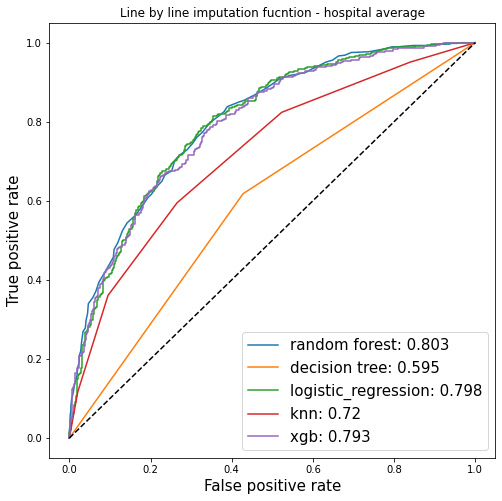

In [212]:
plt.figure(figsize=(8, 8))
for idx, preds in enumerate([rf_preds, tree_preds, lr_preds, knn_preds, xgb_preds]):
    fpr, tpr, _ = metrics.roc_curve(y_score=preds[:,1], y_true=data_raw['Prognosis'].apply(lambda x: 0 if x =='MILD' else 1))
    auc = np.round(metrics.roc_auc_score(y_score=preds[:,1], y_true=data_raw['Prognosis'].apply(lambda x: 0 if x =='MILD' else 1)), 3)
    plt.plot(fpr, tpr, label=['random forest', 'decision tree', 'logistic_regression', 'knn', 'xgb'][idx] + f': {auc}')
plt.legend(fontsize=15)
plt.plot([0, 1], [0, 1], '--', c='k')
plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate', fontsize=15)
plt.title('Line by line imputation fucntion - hospital average')

## 9. Test data - EDA <a class="anchor" id="testdataeda"></a>

In [10]:
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('ggplot')

In [11]:
train = pd.read_excel('../data/raw_data/trainClinData.xls')
test = pd.read_excel('../data/raw_data/testClinData.xls')

train['Prognosis'] = train['Prognosis'].apply(lambda x: 0 if x =='MILD' else 1)
test['Prognosis'] = test['Prognosis'].apply(lambda x: 0 if x =='MILD' else 1)

train['isTrain'] = True
test['isTrain'] = False

tt = pd.concat([train, test]).reset_index(drop=True).copy()

In [12]:
train.shape, test.shape, tt.shape

((1103, 41), (486, 41), (1589, 41))

<AxesSubplot:title={'center':'% of Values Missing'}>

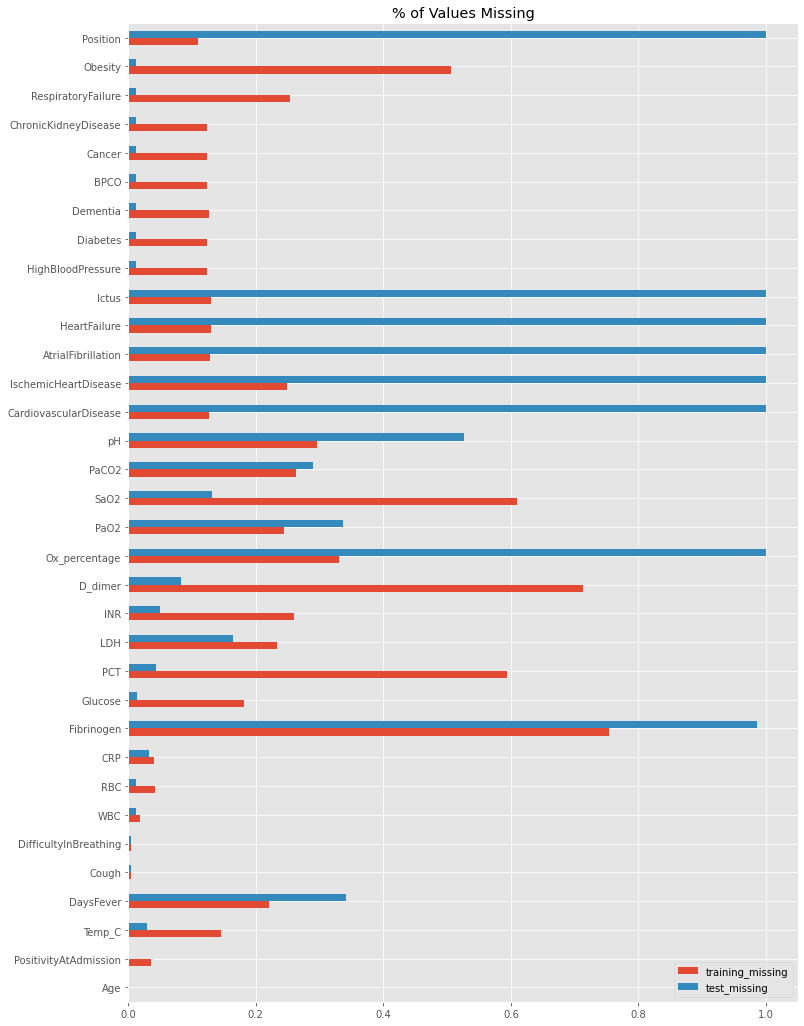

In [31]:
ncounts = pd.DataFrame([train.isna().mean(), test.isna().mean()]).T
ncounts = ncounts.rename(columns={0:'training_missing', 1:'test_missing'})
ncounts.query('training_missing >0').plot(kind='barh', figsize=(12,18), title='% of Values Missing')

In [14]:
nacols = list(ncounts.query('training_missing >0').index.values)

In [15]:
continuous_features = ["Age","Temp_C","DaysFever","WBC","RBC","CRP","Fibrinogen","Glucose","PCT","LDH","INR","D_dimer","Ox_percentage","PaO2","SaO2","PaCO2","pH"]
discrete_features = ["Sex","PositivityAtAdmission","Cough","DifficultyInBreathing","CardiovascularDisease","IschemicHeartDisease","AtrialFibrillation","HeartFailure",
                         "Ictus","HighBloodPressure","Diabetes","Dementia","BPCO","Cancer","ChronicKidneyDisease","RespiratoryFailure","Obesity","Position"]

In [16]:
tt["n_missing"] = tt[nacols].isna().sum(axis=1)
train["n_missing"] = train[nacols].isna().sum(axis=1)
test["n_missing"] = test[nacols].isna().sum(axis=1)

In [17]:
train.groupby('Prognosis')['n_missing'].mean()

Prognosis
0    7.721495
1    7.038732
Name: n_missing, dtype: float64

In [18]:
# a bit more missing values for Prognosis=0 patients

In [19]:
# try predicting the prognosis with only missing values 

In [20]:
tt_missing_tag_df = tt[nacols].isna()
tt_missing_tag_df.columns = [f"{c}_missing" for c in tt_missing_tag_df.columns]
tt = pd.concat([tt, tt_missing_tag_df], axis=1)

In [21]:
nacols_missing = [s + '_missing' for s in nacols]

In [22]:
from sklearn.linear_model import LogisticRegressionCV

lr = LogisticRegressionCV(scoring="accuracy")

In [23]:
X = tt.query("isTrain")[nacols_missing]
y = tt.query("isTrain")['Prognosis']

In [24]:
lr.fit(X, y)

LogisticRegressionCV(scoring='accuracy')

In [25]:
lr.score(X, y)

0.5902085222121487

In [26]:
preds = lr.predict_proba(X)[:, 0]

In [27]:
metrics.roc_auc_score(y, preds)

0.3598394102935369

In [ ]:
# fortunately this is not possible